In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
import random

In [12]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),
              dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                  interval=50)
    anim.save('movie_cartpole_DQN.mp4')
    display(display_animation(anim, default_mode='loop'))

In [3]:
#namedtuple実装例
from collections import namedtuple

Tr = namedtuple('tr', ('name_a', 'value_b'))
Tr_object = Tr('名前Aです', 100)

print(Tr_object)
print(Tr_object.value_b)

tr(name_a='名前Aです', value_b=100)
100


In [4]:
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

In [5]:
ENV = 'CartPole-v0'
GAMMA = 0.99
MAX_STEPS = 200
NUM_EPISODES = 500

In [6]:
class ReplayMemory:

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY
        self.memory = []
        self.index = 0

    def push(self, state, action, state_next, reward):

        if len(self.memory) < self.capacity:
            self.memory.append(None)

        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000

class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions
        self.memory = ReplayMemory(CAPACITY)

        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))

        print(self.model)

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        self.model.eval()
        state_action_values = self.model(state_batch).gather(1, action_batch)

        non_final_mask = torch.ByteTensor(
            tuple(map(lambda s: s is not None, batch.next_state)))
        next_state_values = torch.zeros(BATCH_SIZE)

        next_state_values[non_final_mask] = self.model(
            non_final_next_states).max(1)[0].detach()
        
        expected_state_action_values = reward_batch + GAMMA * next_state_values

        self.model.train()

        loss = F.smooth_l1_loss(state_action_values,expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def decide_action(self, state, episode):
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
        else:
            action = torch.LongTensor([[random.randrange(self.num_actions)]])

        return action

In [8]:
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)
    
    def update_q_function(self):
        self.brain.replay()

    def get_acton(self, state, episode):
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        self.brain.memory.push(state, action, state_next, reward)

In [9]:
class Environment:
    def __init__(self):
        self.env = gym.make(ENV)
        self.num_states = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.n

        self.agent = Agent(self.num_states, self.num_actions)

    def run(self):
        episode_10_list = np.zeros(10)

        complete_episodes = 0
        episode_final = False
        frames = []

        for episode in range(NUM_EPISODES):
            observation = self.env.reset()

            state = observation
            state = torch.from_numpy(state).type(torch.FloatTensor)
            state = torch.unsqueeze(state, 0)

            for step in range(MAX_STEPS):
                if episode_final is True:
                    frames.append(self.env.render(mode = 'rgb_array'))
                
                action = self.agent.get_acton(state, episode)

                observation_next, _, done, _ = self.env.step(action.item())
                if done:
                    state_next = None

                    episode_10_list = np.hstack((episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor([-1.0])
                        complete_episodes = 0
                    else:
                        reward = torch.FloatTensor([1.0])
                        complete_episodes = complete_episodes + 1
                else:
                    reward = torch.FloatTensor([0.0])
                    state_next = observation_next
                    state_next = torch.from_numpy(state_next).type(torch.FloatTensor)
                    state_next = torch.unsqueeze(state_next, 0)

                self.agent.memorize(state, action, state_next, reward)

                self.agent.update_q_function()

                state = state_next

                if done:
                    print('%d Episode: Finished after %d steps : 10試行の平均step数 = %.1f' %(episode, step + 1, episode_10_list.mean()))
                    break

            if episode_final is True:
                display_frames_as_gif(frames)
                break

            if complete_episodes >= 10:
                print('10回連続成功')
                episode_final = True

Sequential(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 19 steps : 10試行の平均step数 = 1.9
1 Episode: Finished after 17 steps : 10試行の平均step数 = 3.6
2 Episode: Finished after 17 steps : 10試行の平均step数 = 5.3
3 Episode: Finished after 25 steps : 10試行の平均step数 = 7.8
4 Episode: Finished after 20 steps : 10試行の平均step数 = 9.8
5 Episode: Finished after 19 steps : 10試行の平均step数 = 11.7
6 Episode: Finished after 20 steps : 10試行の平均step数 = 13.7


C:\Users\owner\AppData\Local\Temp/ipykernel_10040/2582150128.py:44: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  next_state_values[non_final_mask] = self.model(


7 Episode: Finished after 20 steps : 10試行の平均step数 = 15.7
8 Episode: Finished after 19 steps : 10試行の平均step数 = 17.6
9 Episode: Finished after 21 steps : 10試行の平均step数 = 19.7
10 Episode: Finished after 20 steps : 10試行の平均step数 = 19.8
11 Episode: Finished after 28 steps : 10試行の平均step数 = 20.9
12 Episode: Finished after 28 steps : 10試行の平均step数 = 22.0
13 Episode: Finished after 10 steps : 10試行の平均step数 = 20.5
14 Episode: Finished after 10 steps : 10試行の平均step数 = 19.5
15 Episode: Finished after 18 steps : 10試行の平均step数 = 19.4
16 Episode: Finished after 19 steps : 10試行の平均step数 = 19.3
17 Episode: Finished after 39 steps : 10試行の平均step数 = 21.2
18 Episode: Finished after 24 steps : 10試行の平均step数 = 21.7
19 Episode: Finished after 30 steps : 10試行の平均step数 = 22.6
20 Episode: Finished after 36 steps : 10試行の平均step数 = 24.2
21 Episode: Finished after 45 steps : 10試行の平均step数 = 25.9
22 Episode: Finished after 47 steps : 10試行の平均step数 = 27.8
23 Episode: Finished after 172 steps : 10試行の平均step数 = 44.0
24 Episode: Fini


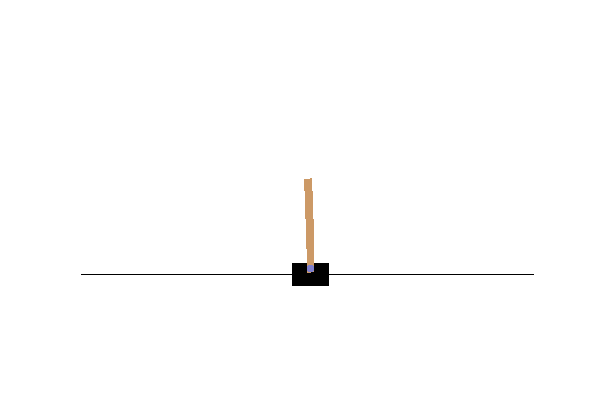
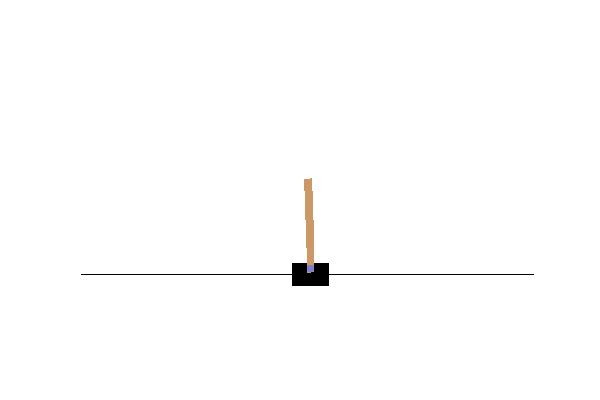
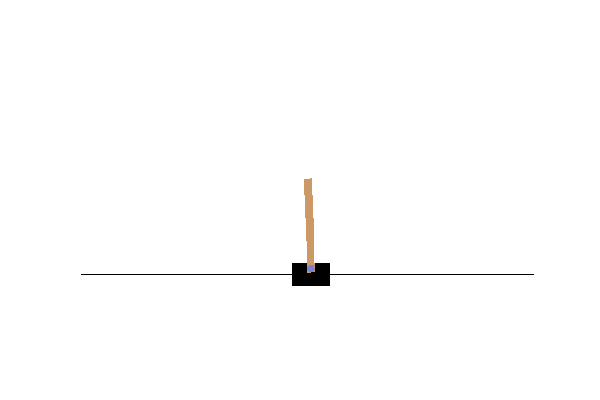
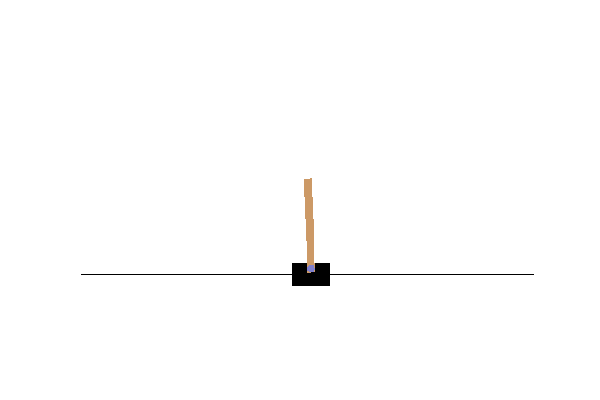
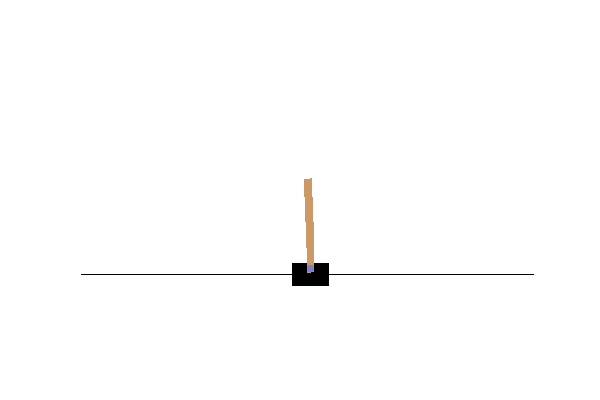
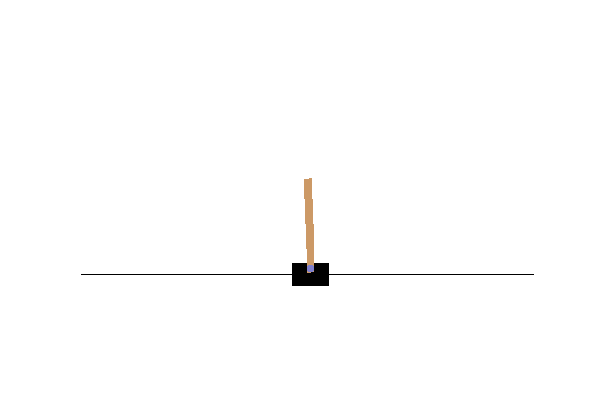
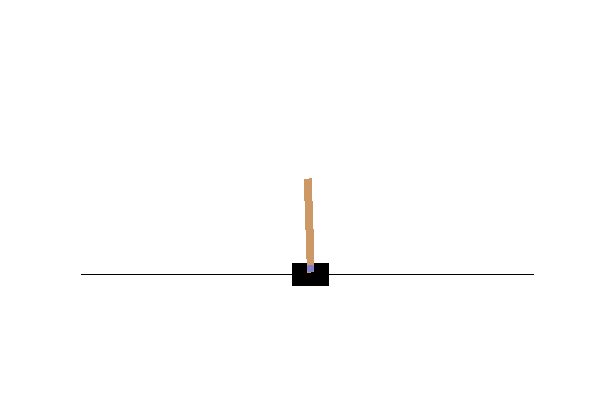
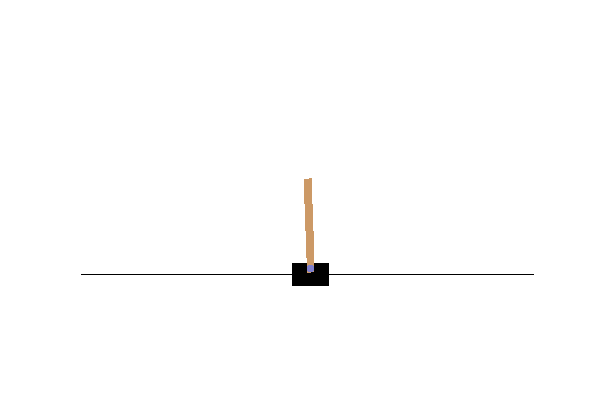
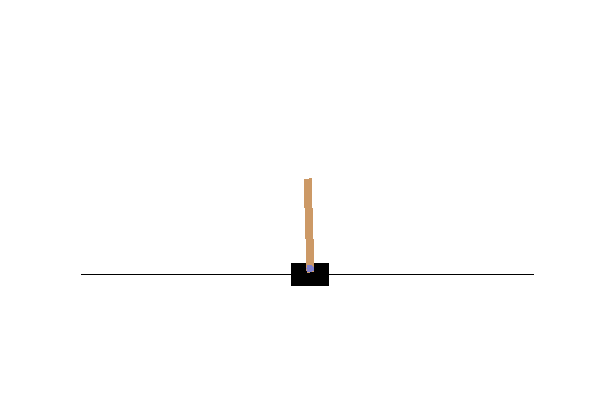
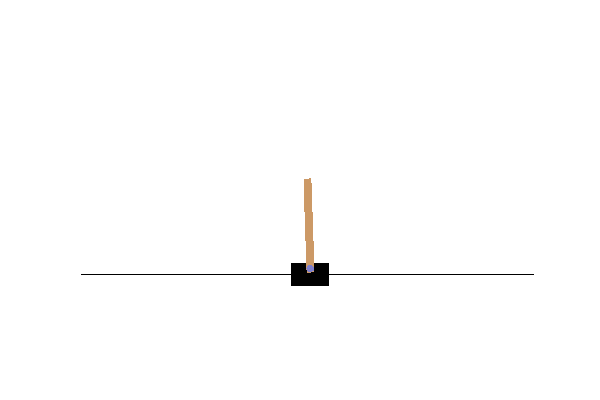
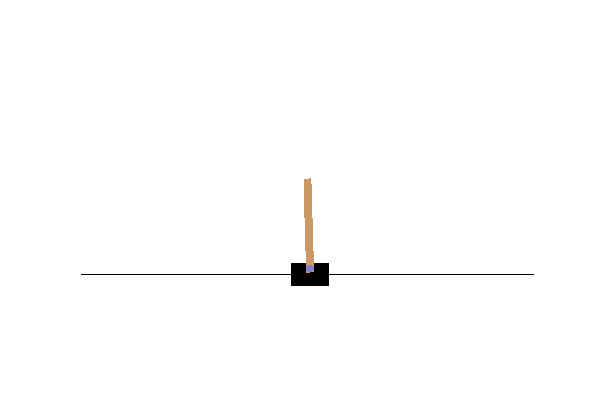
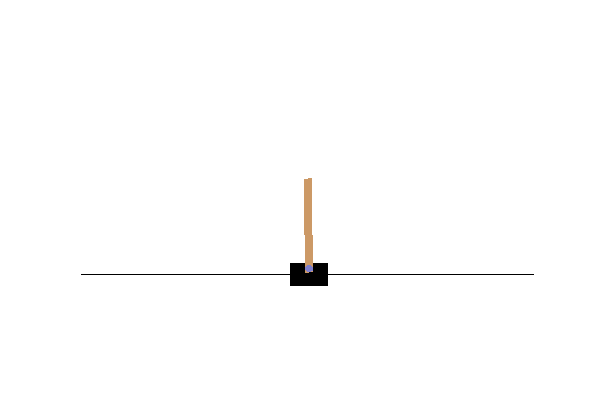
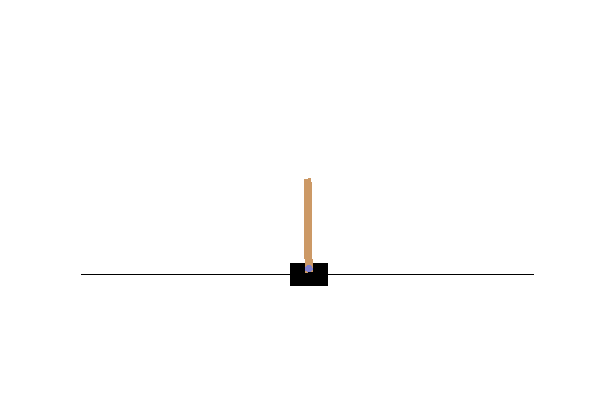
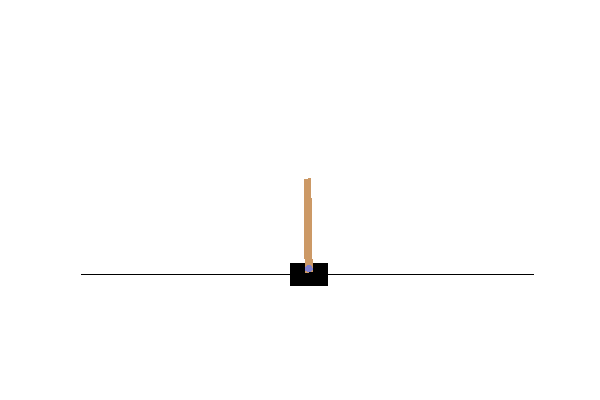
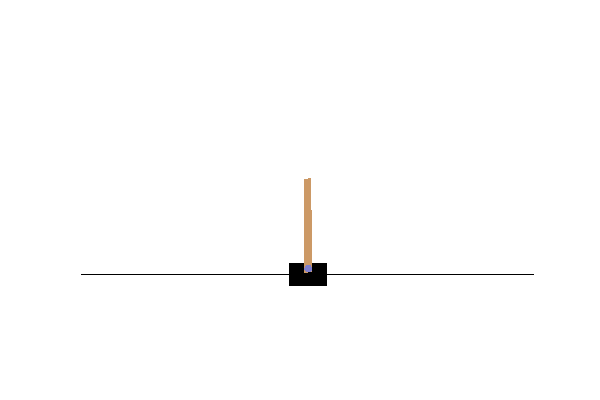
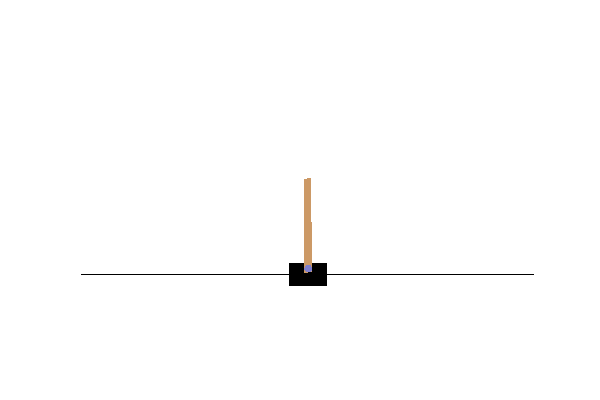
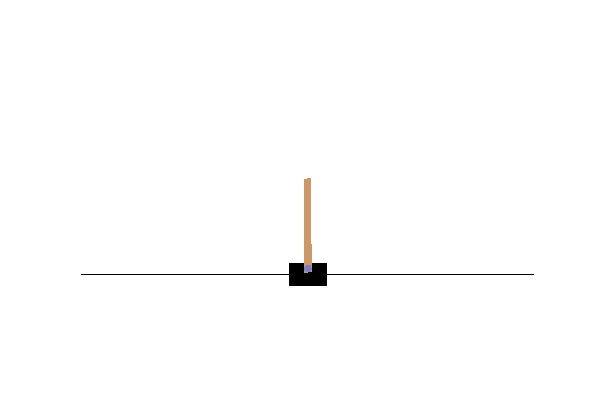
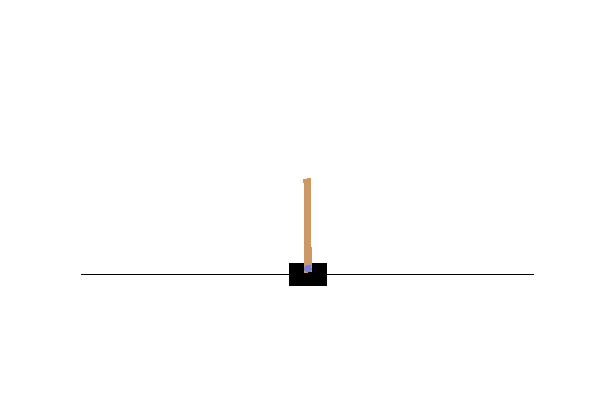
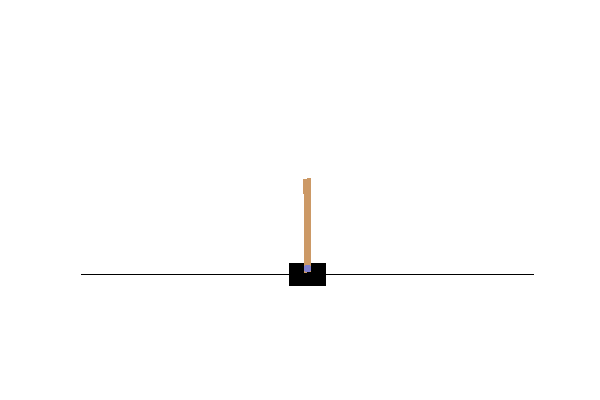
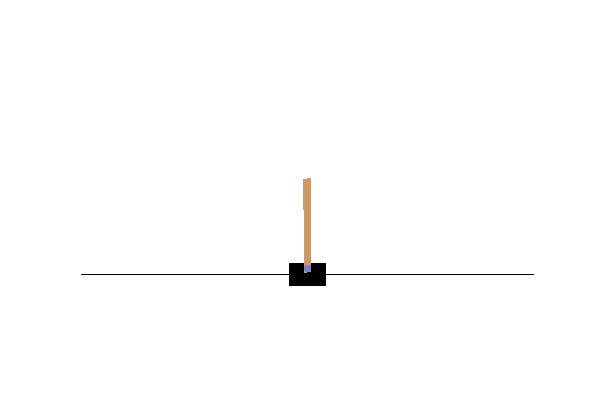
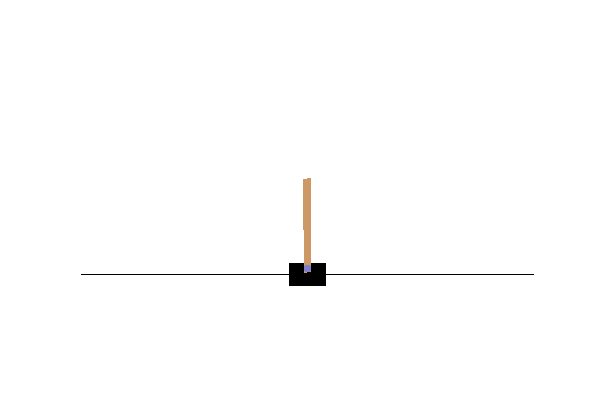
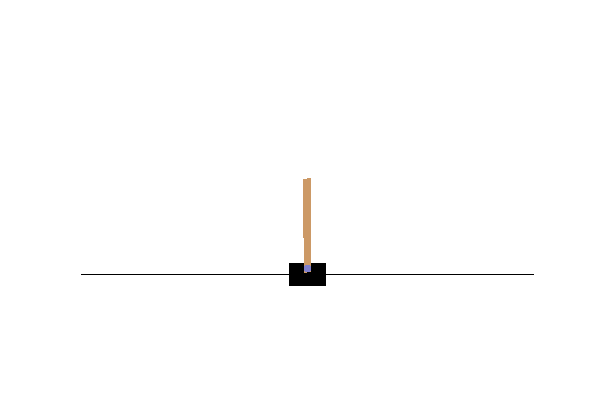
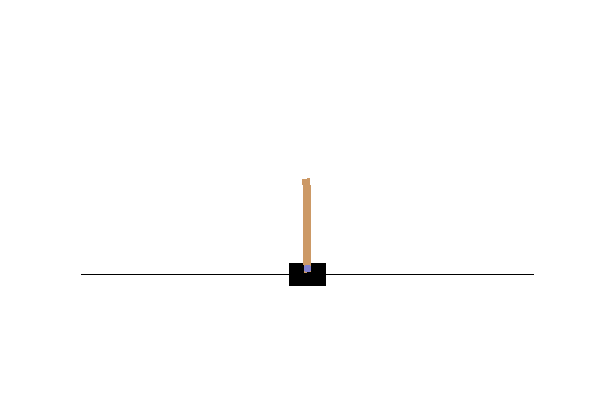
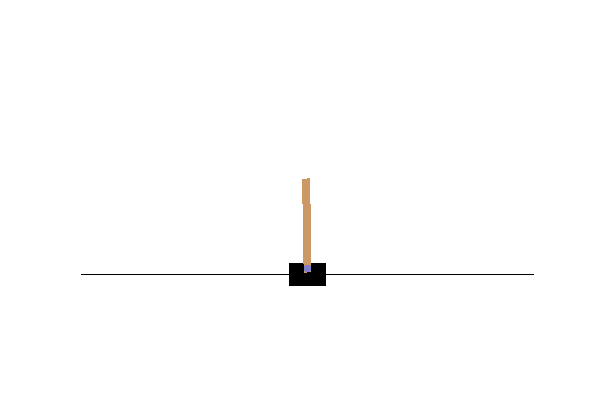
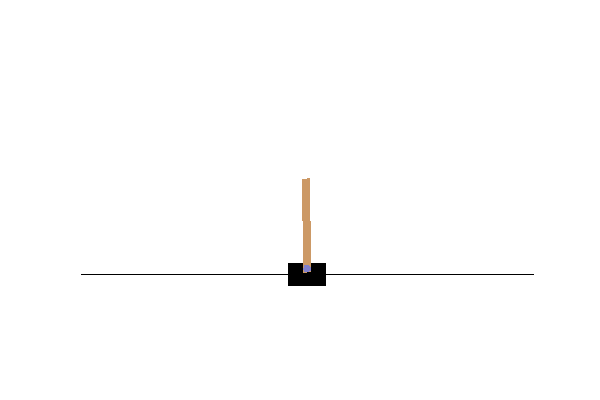
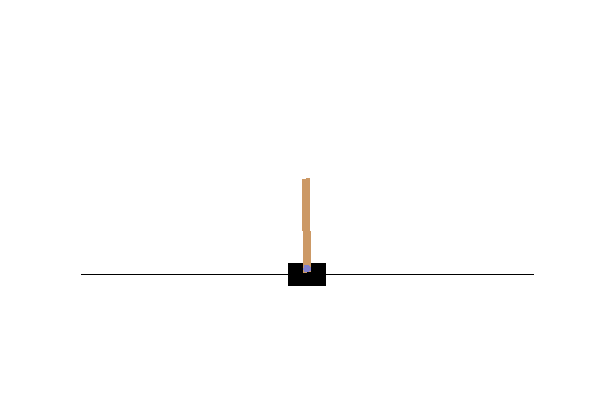
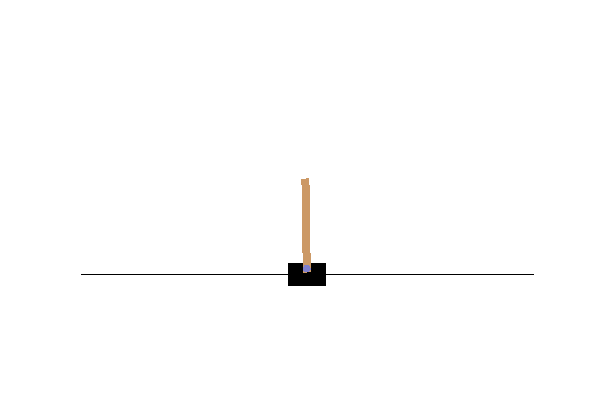
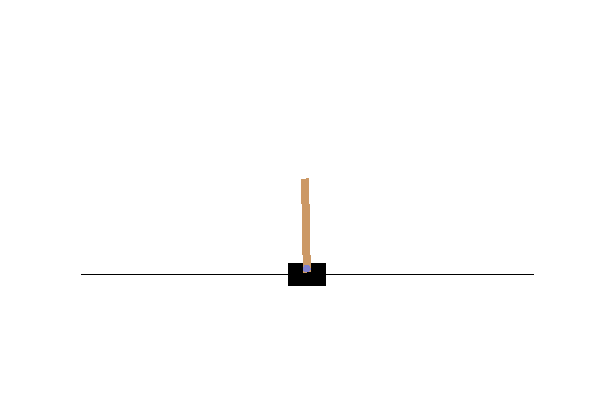
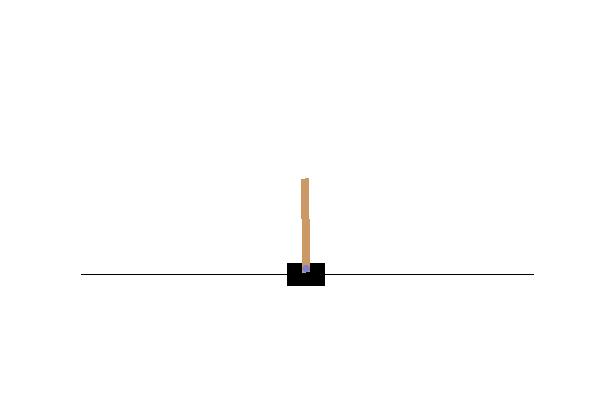
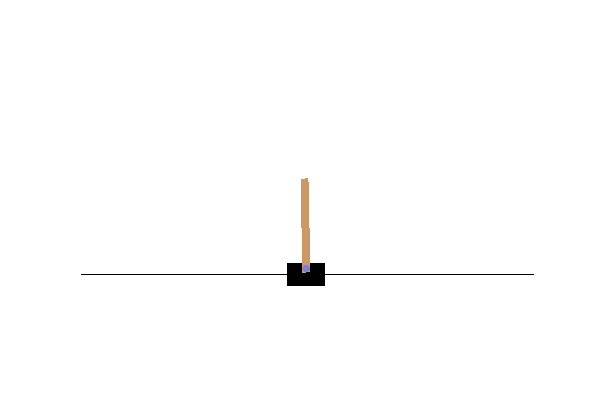
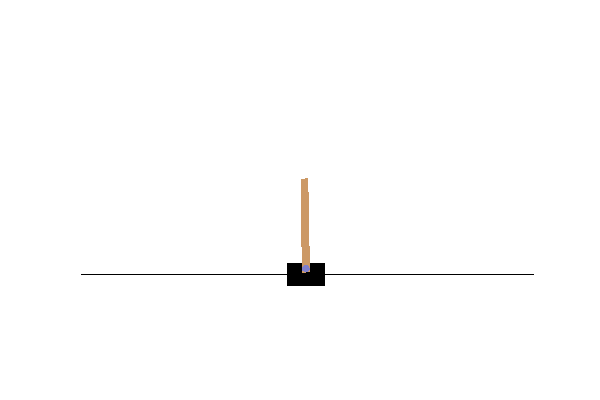
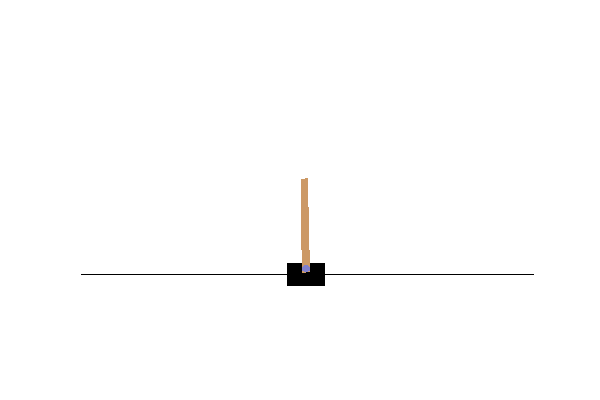
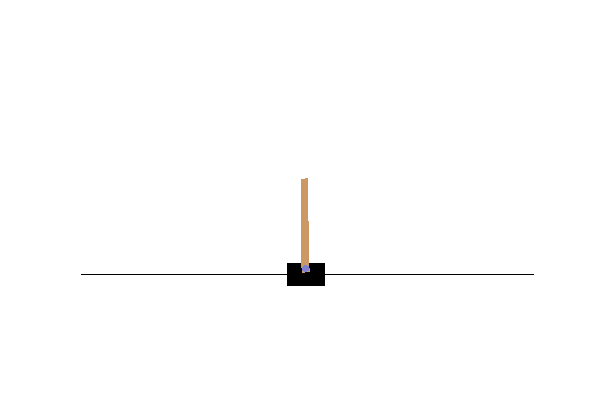
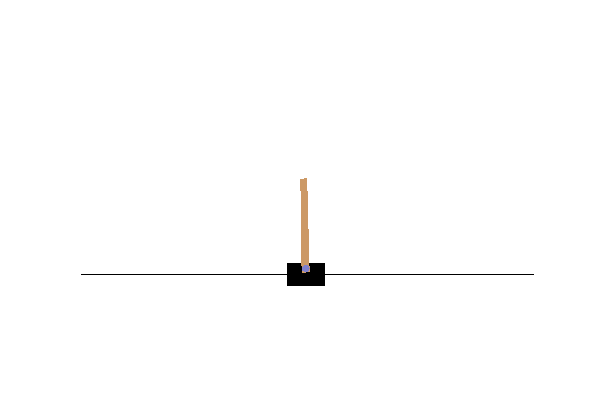
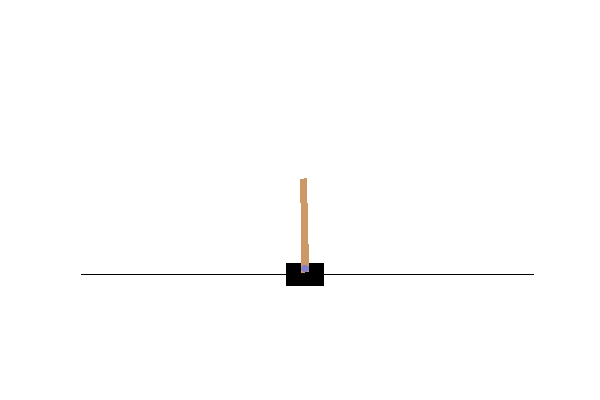
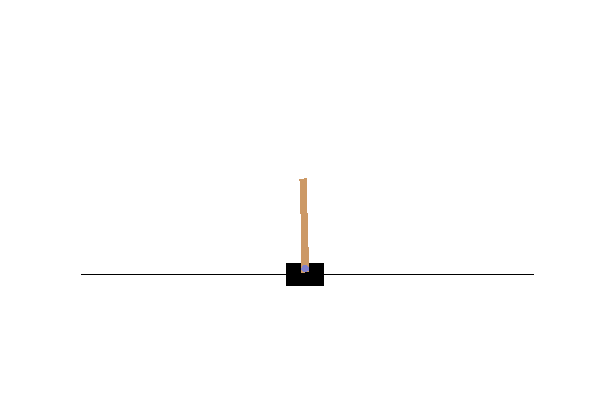
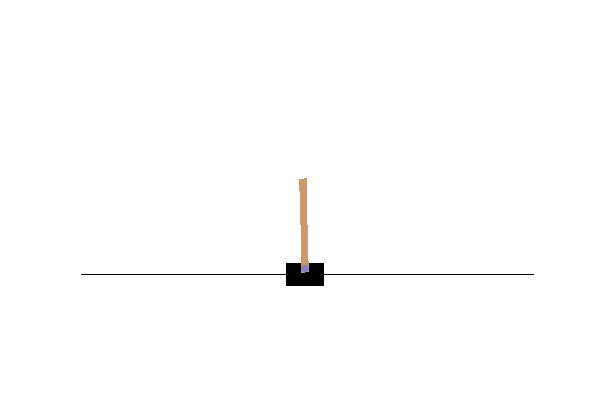
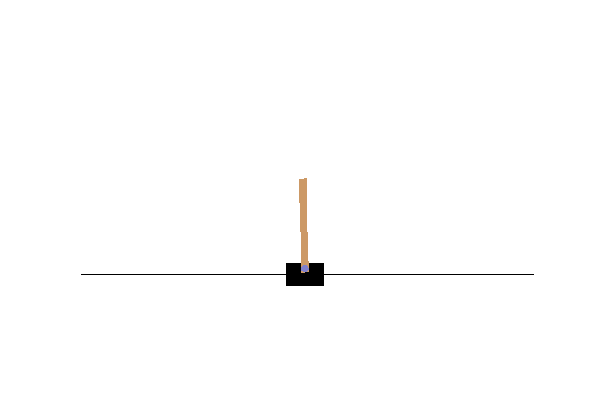
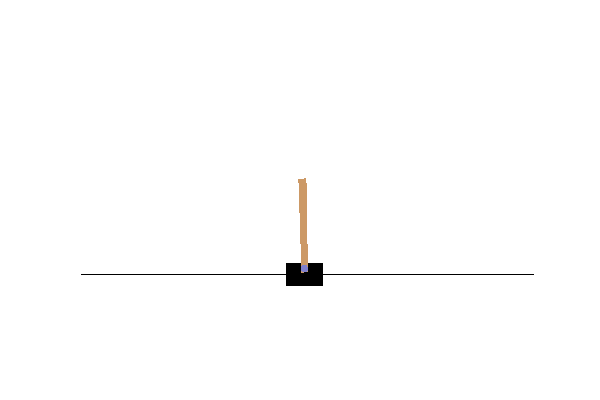
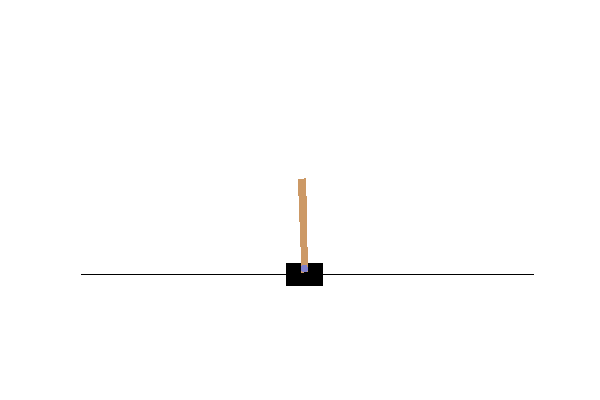
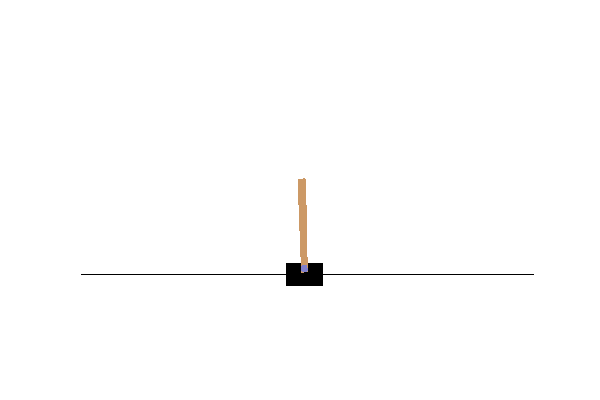
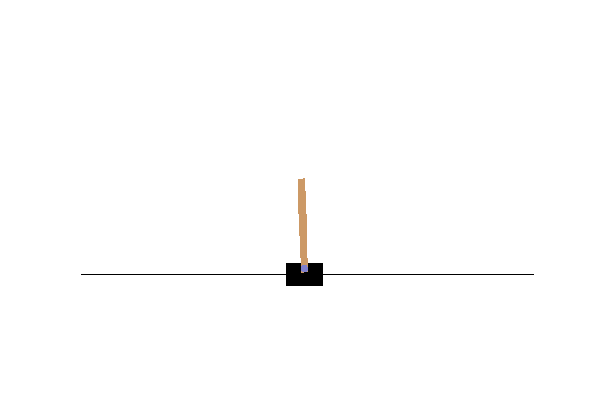
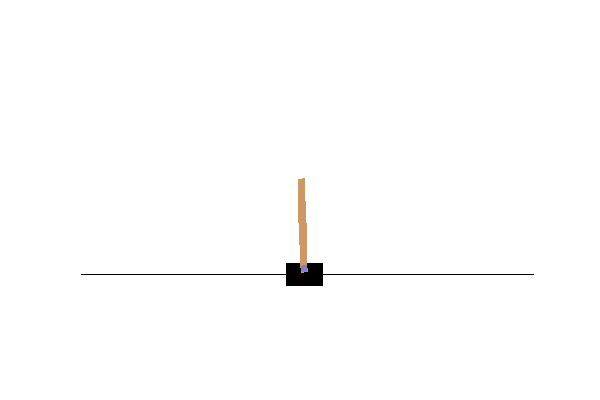
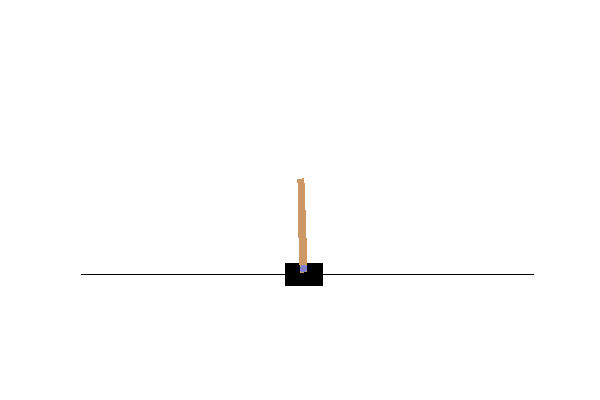
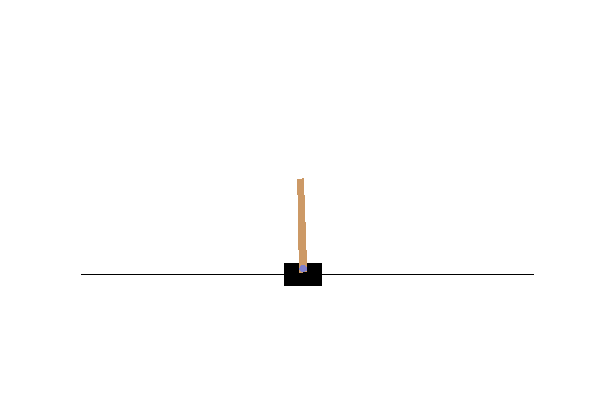
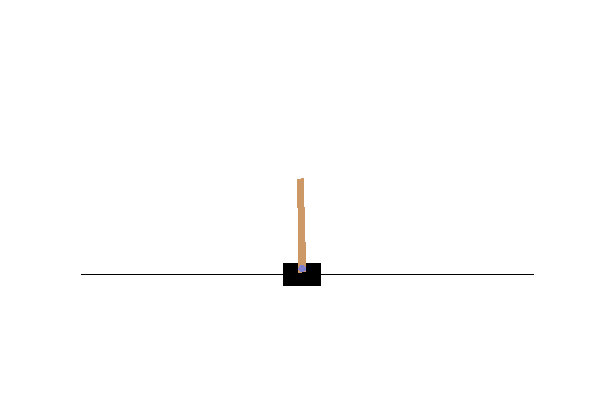
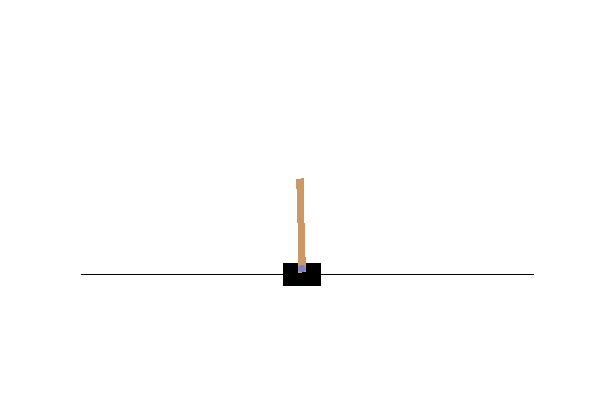
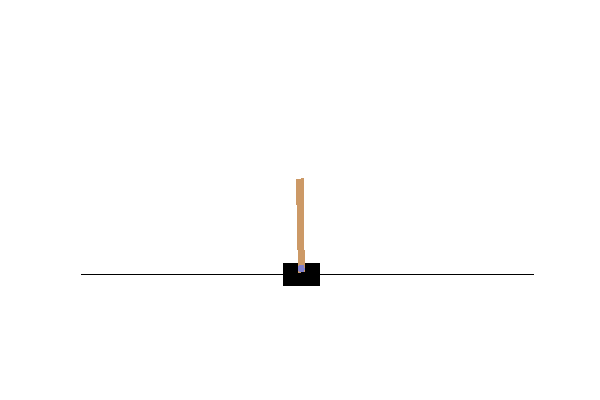
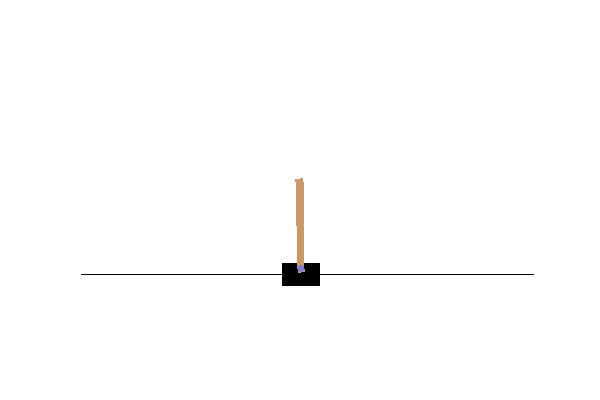
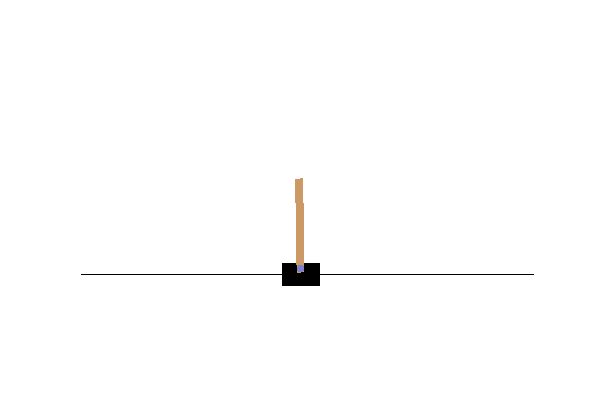
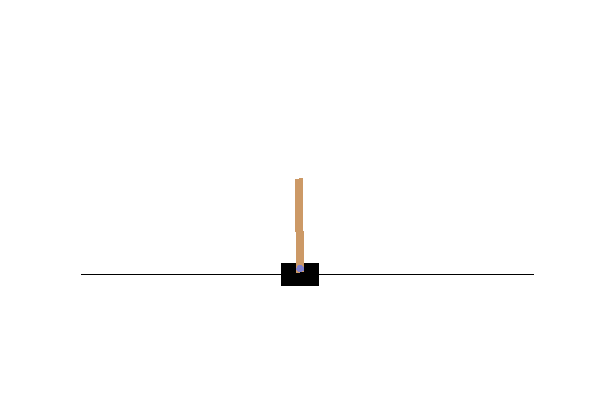
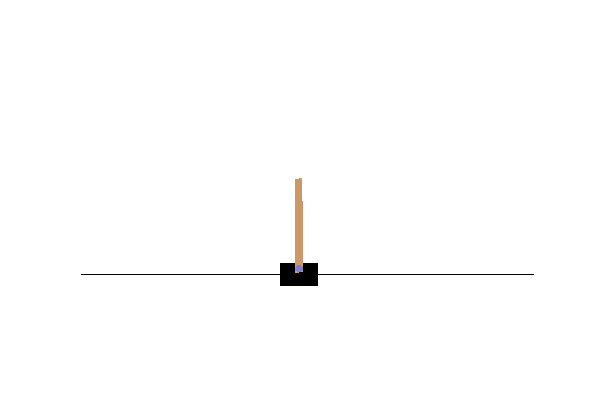
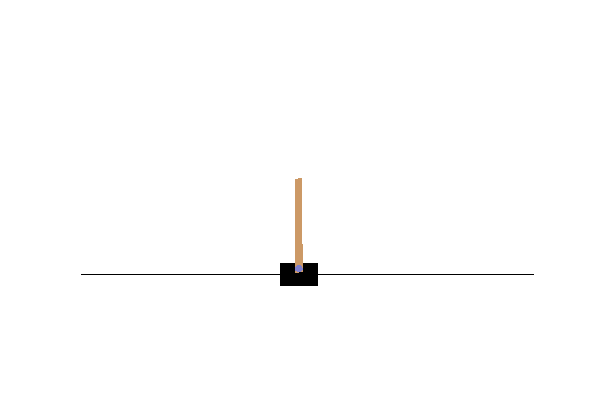
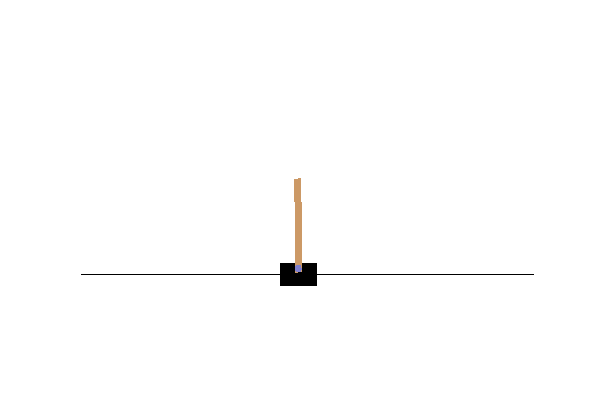
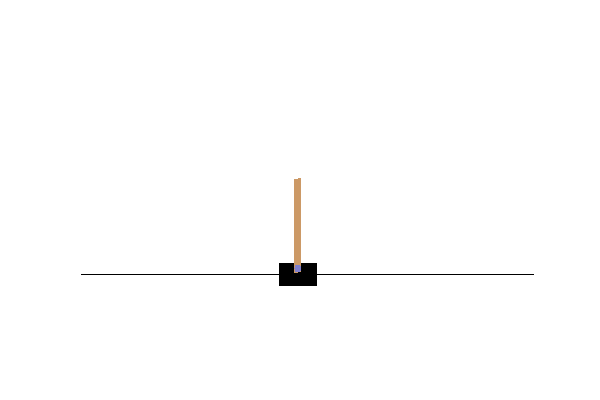
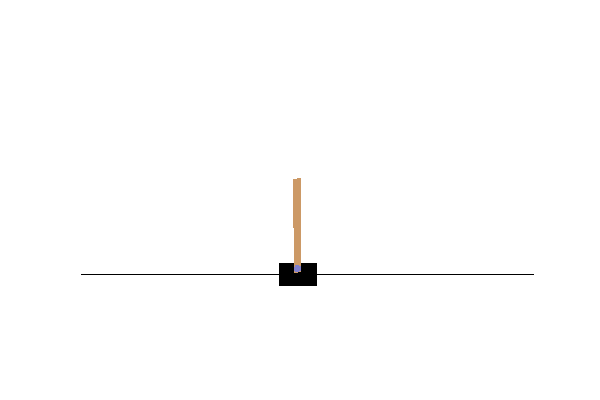
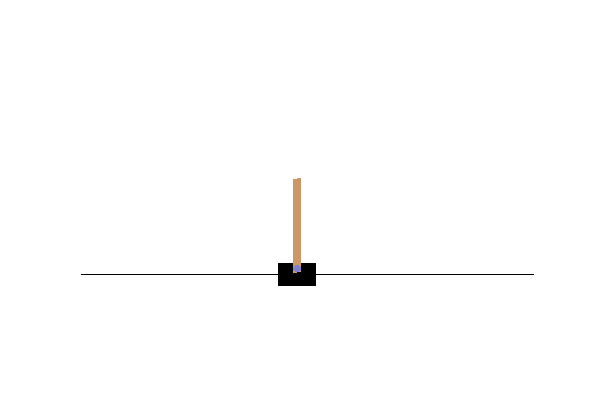
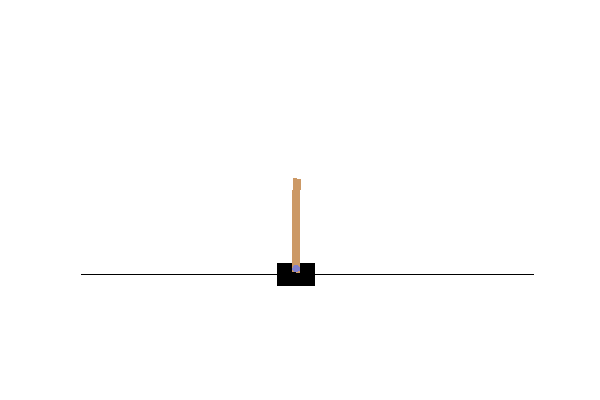
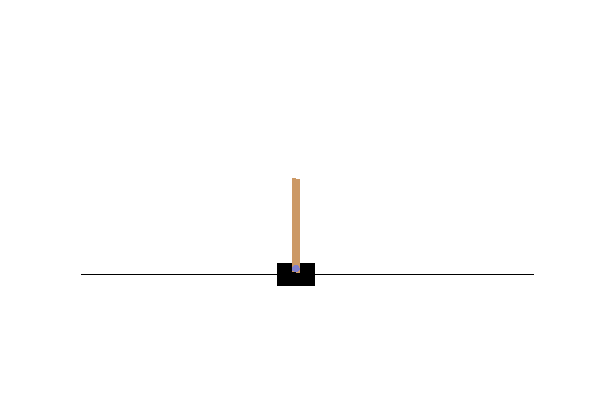
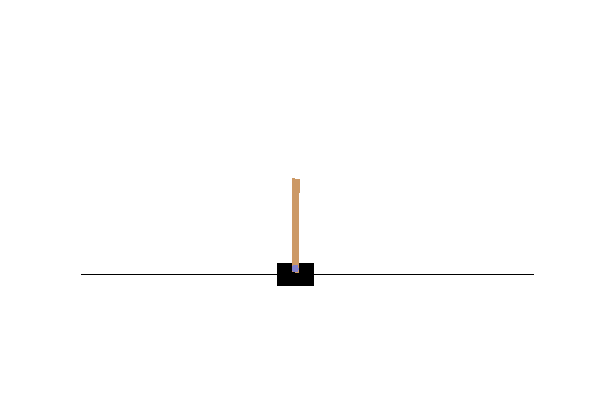
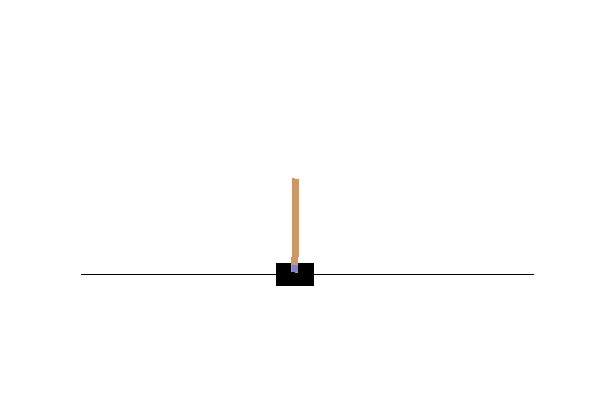
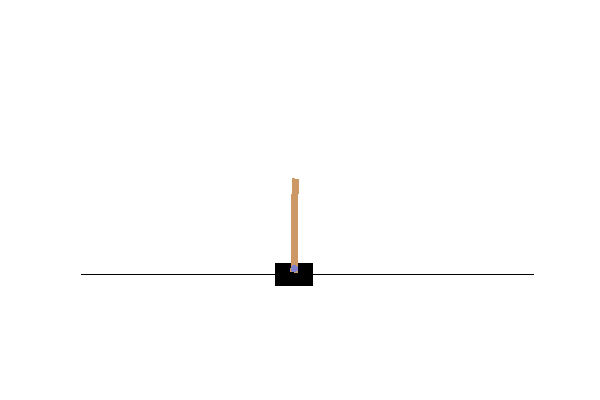
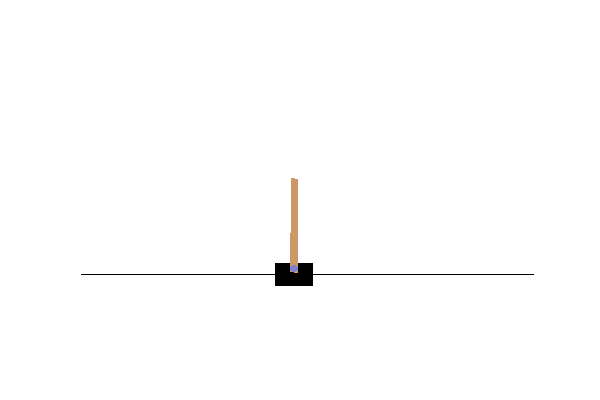
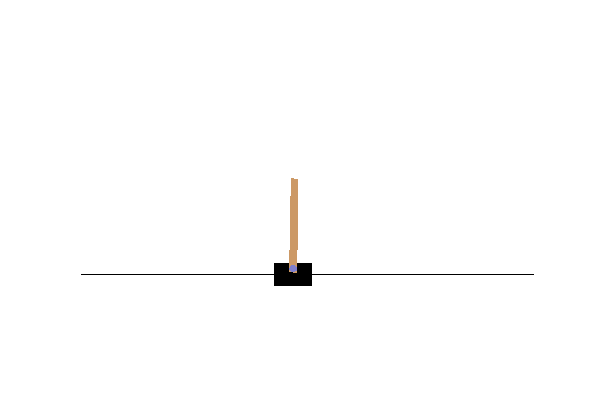
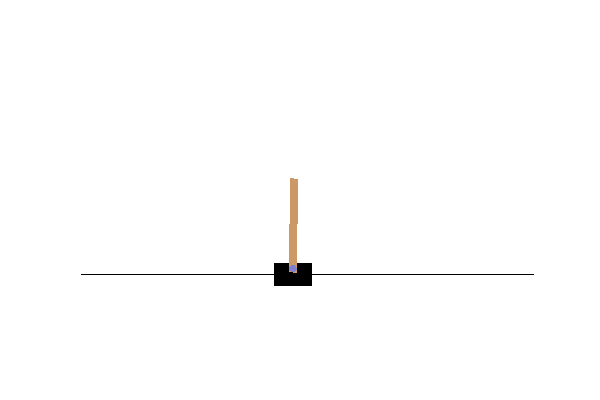
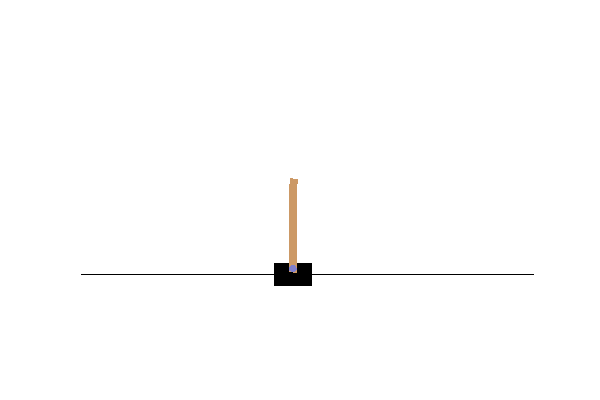
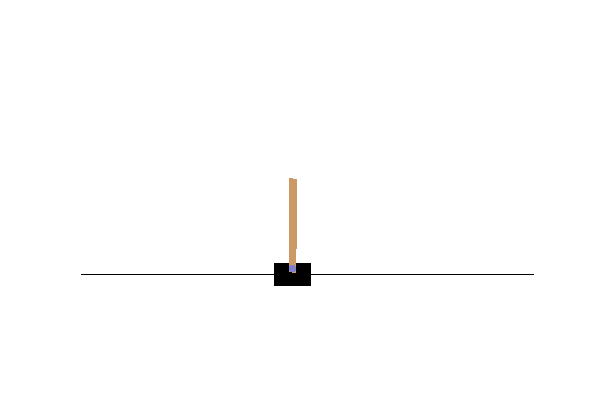
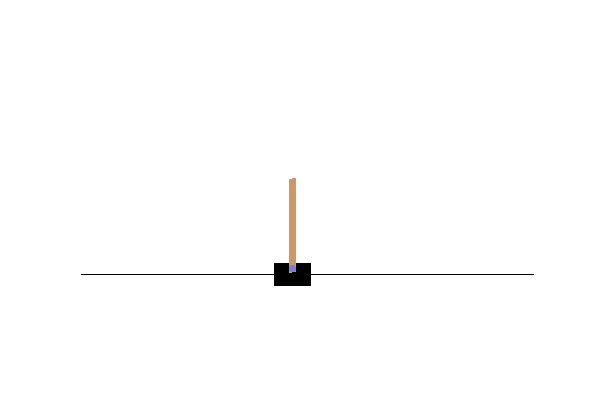
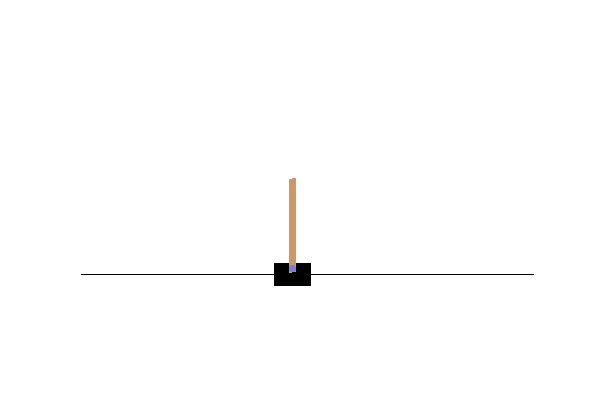
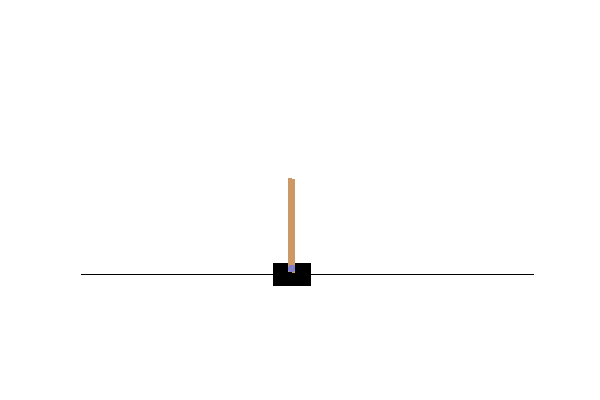
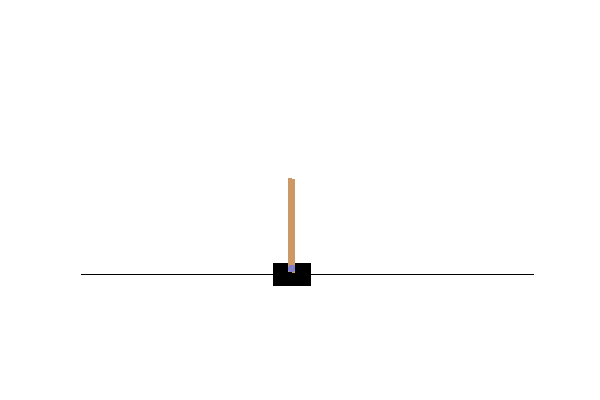
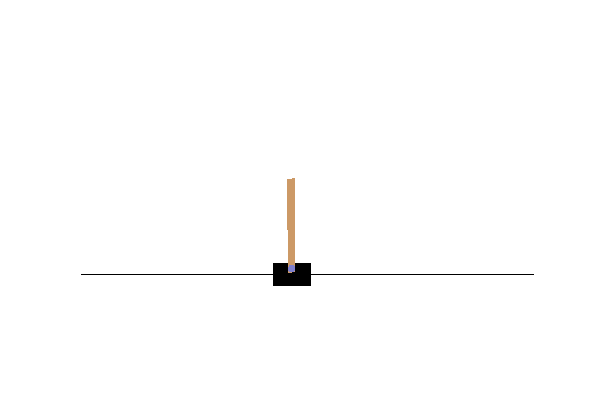
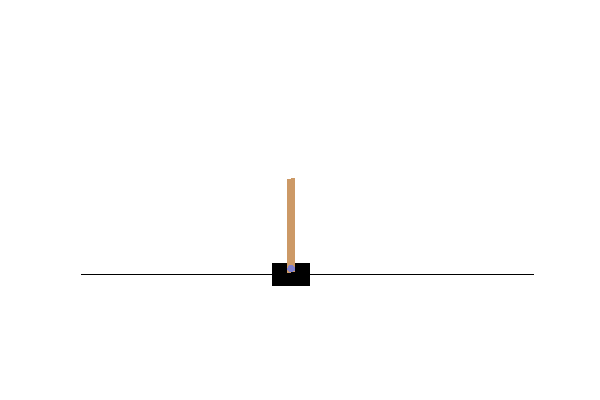
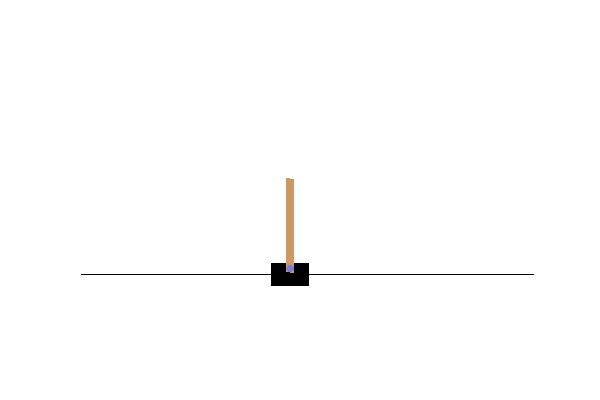
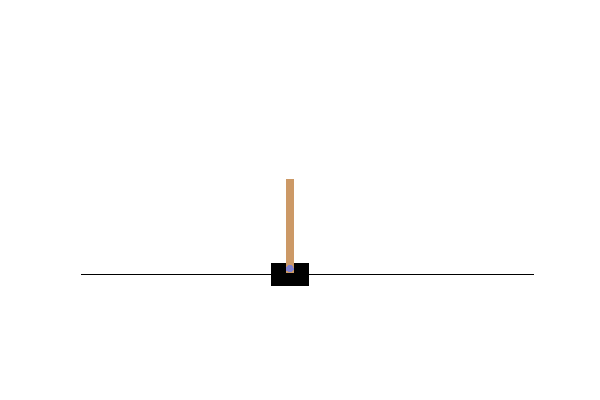
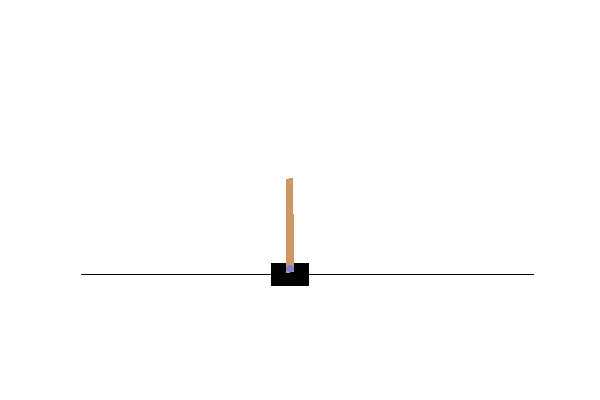
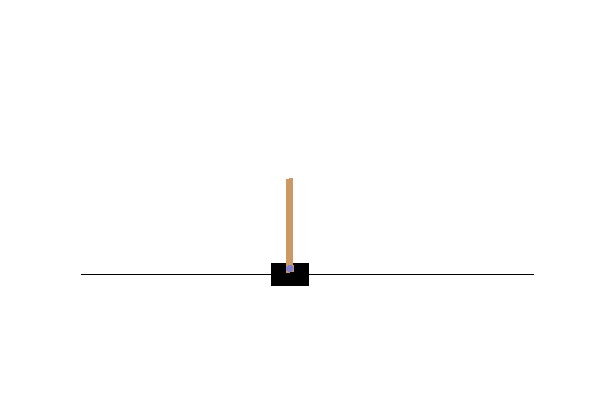
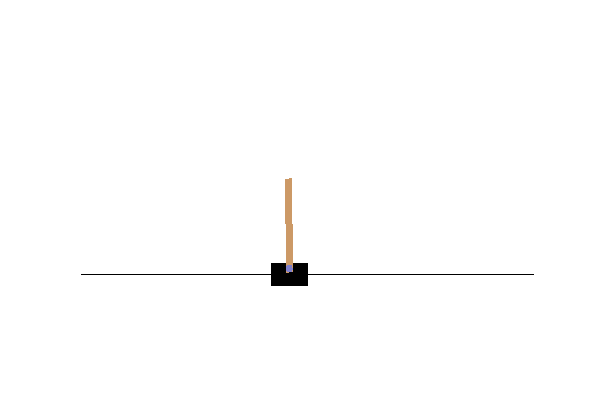
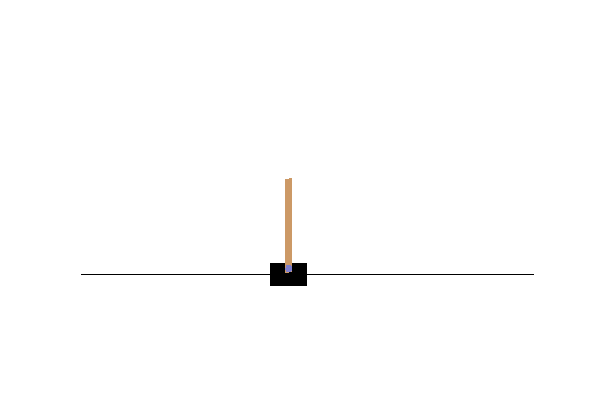
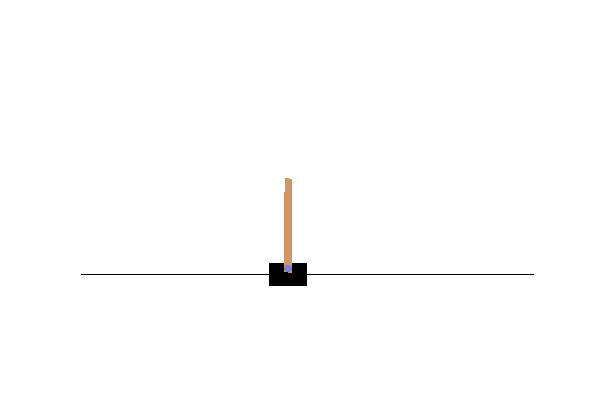
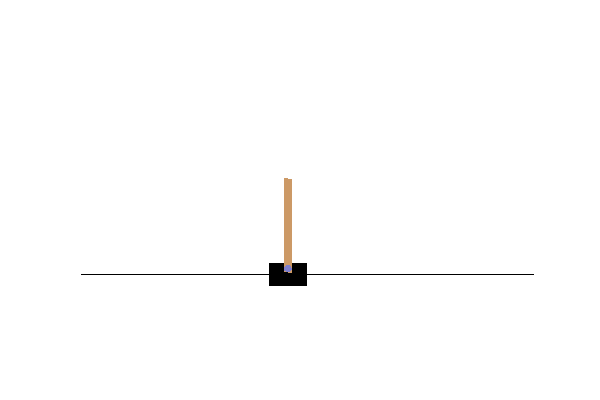
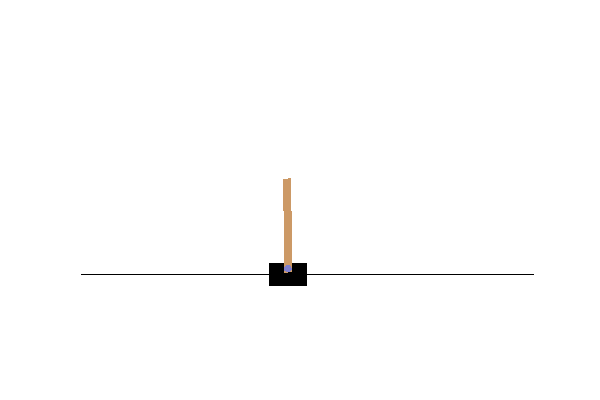
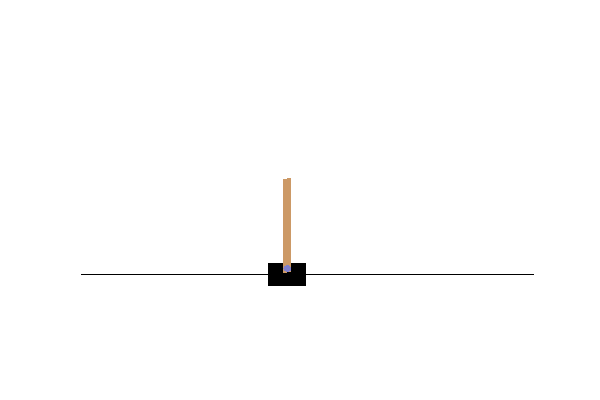
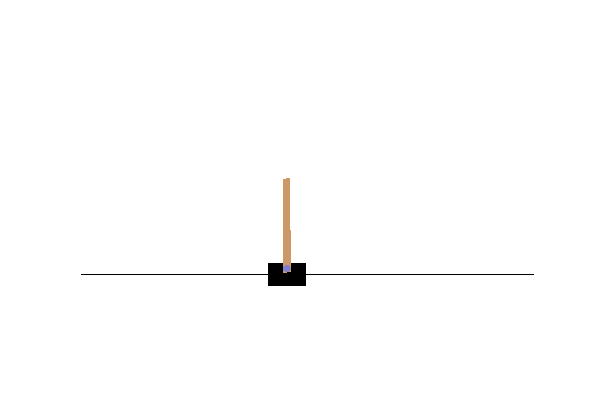
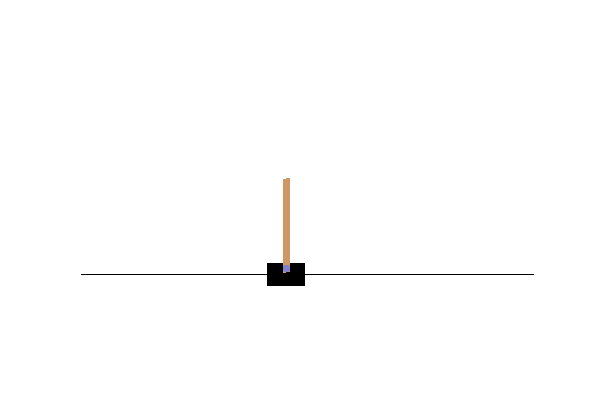
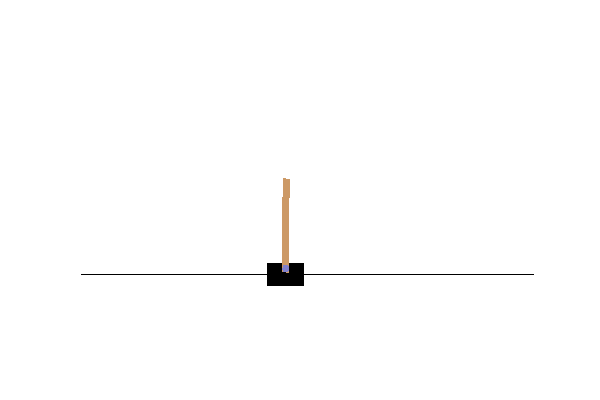
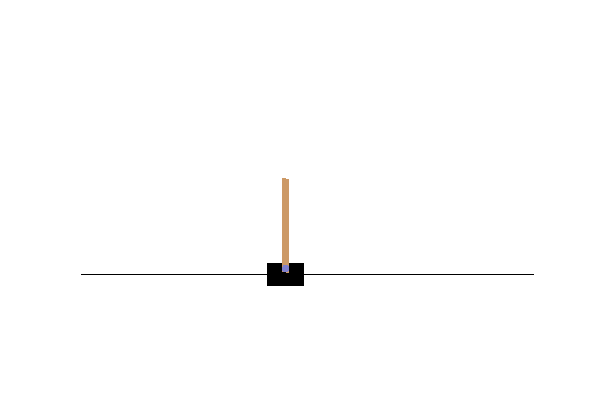
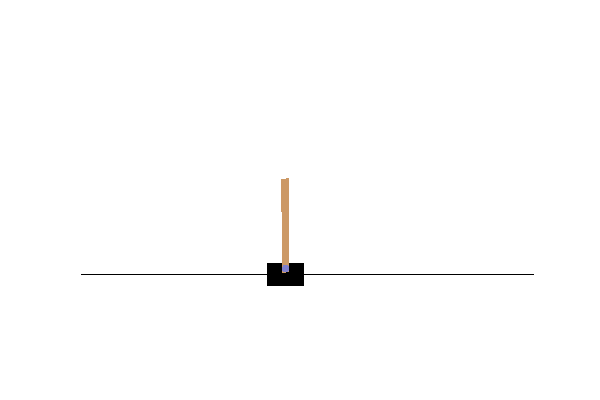
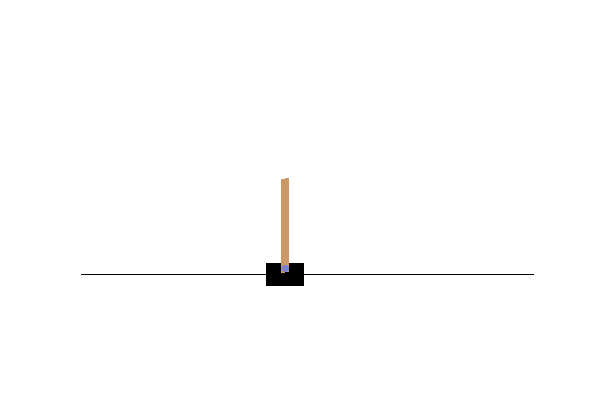
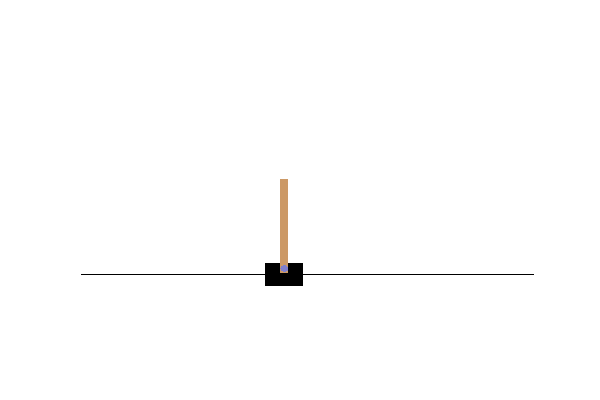
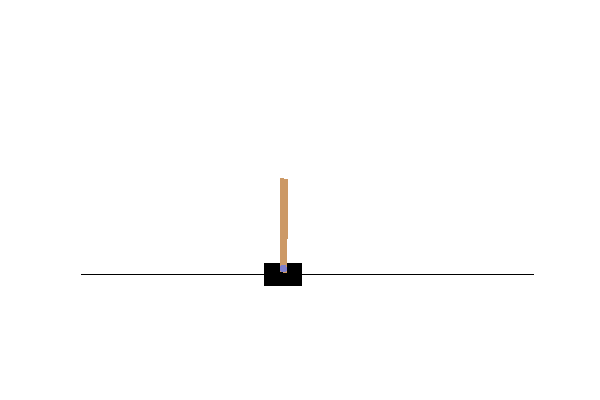
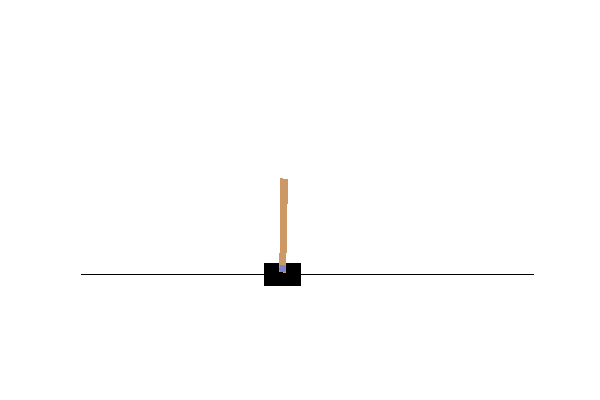
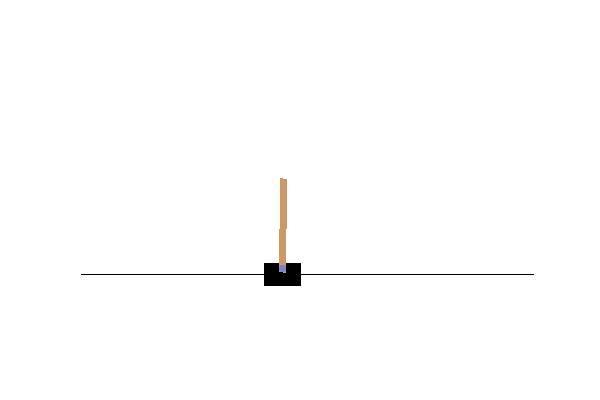
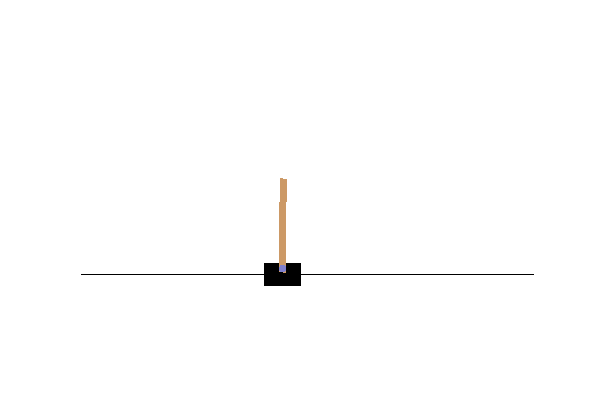
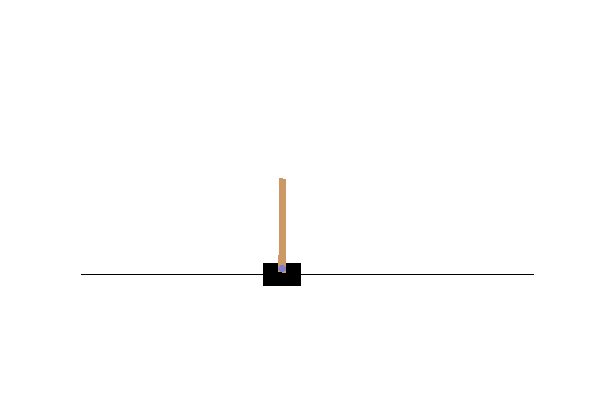
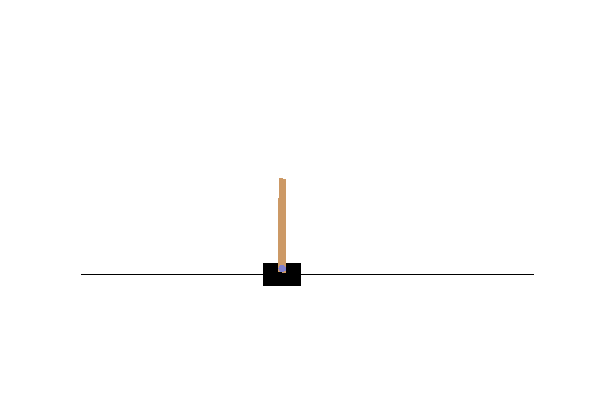
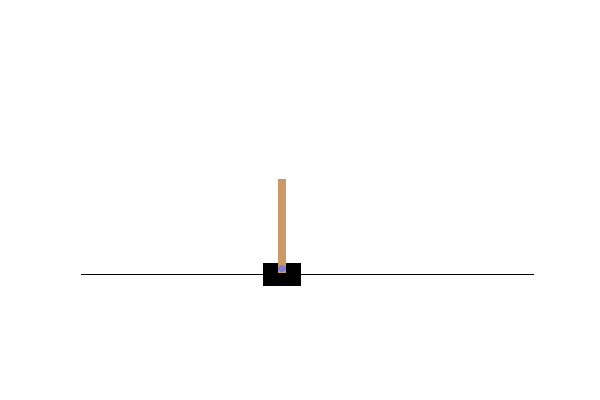
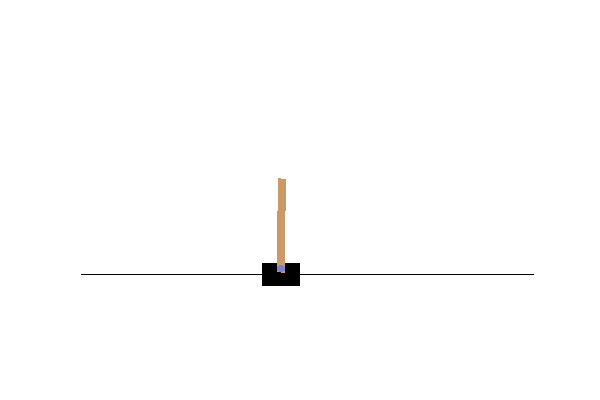
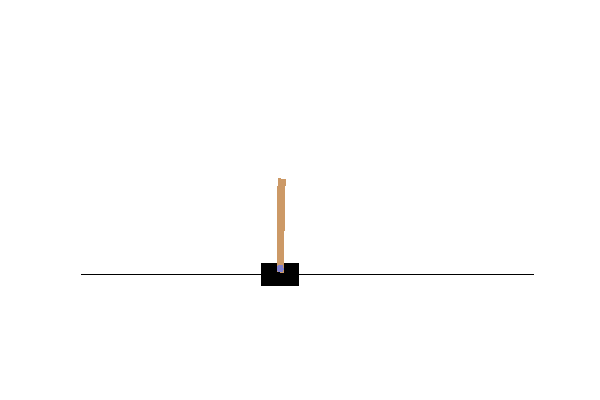
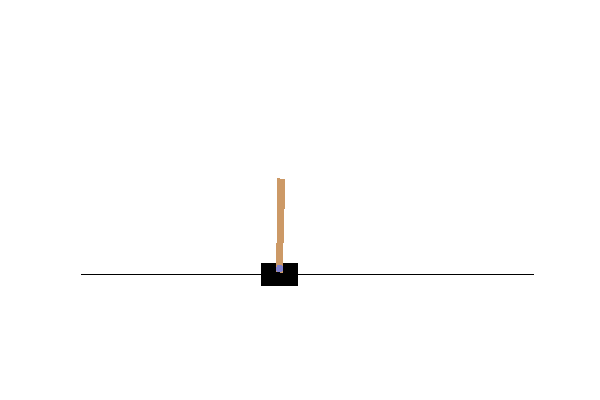
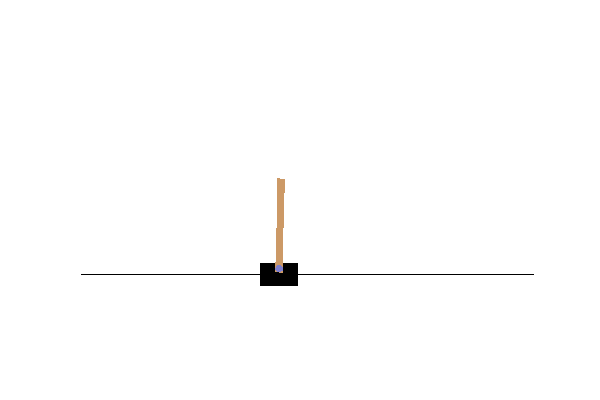
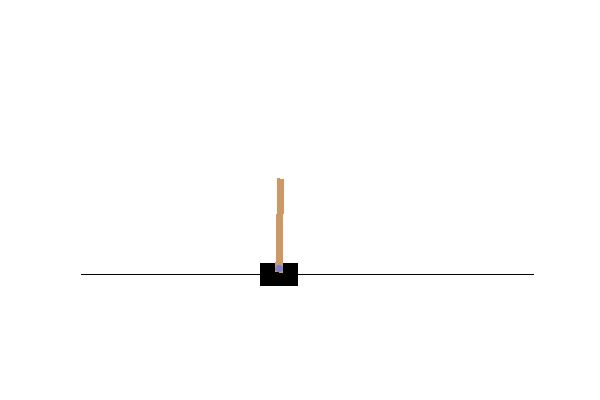
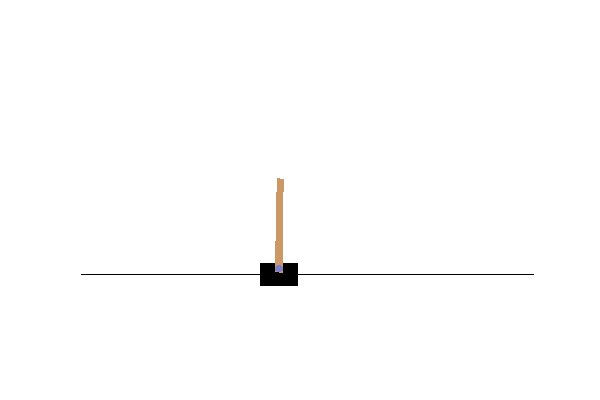
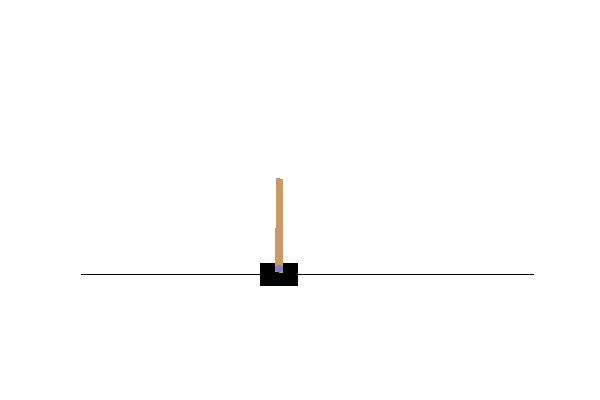
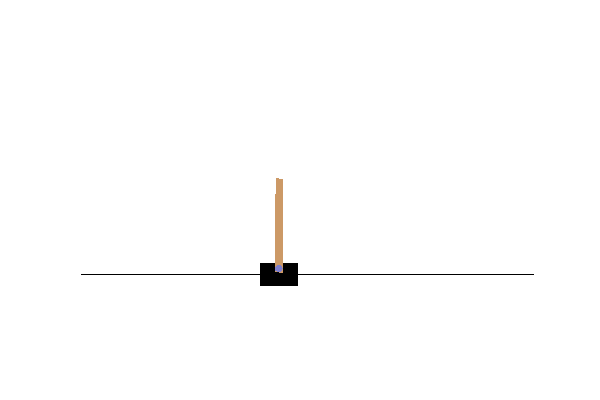
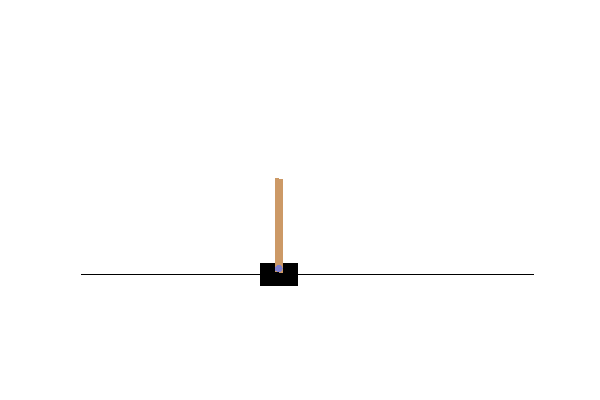
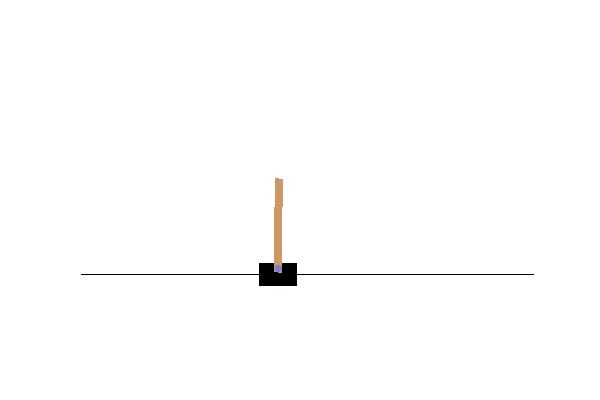
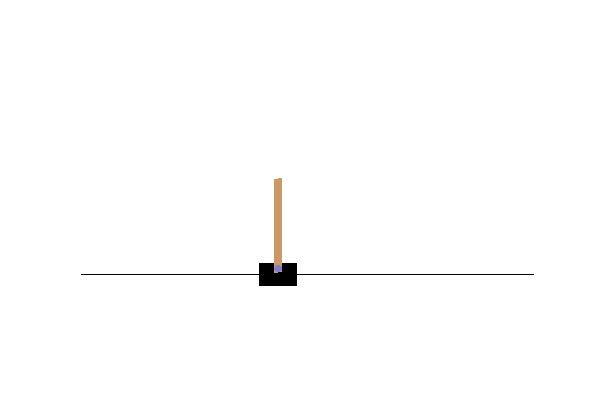
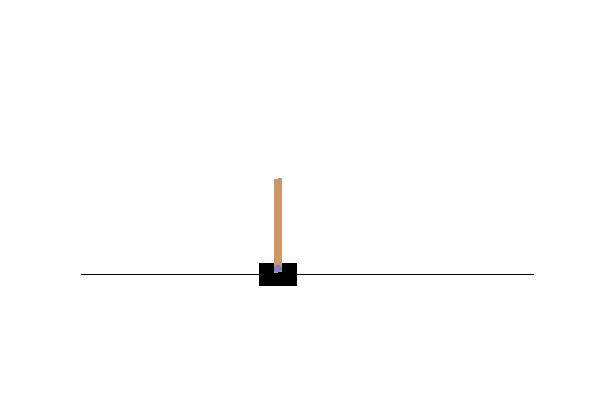
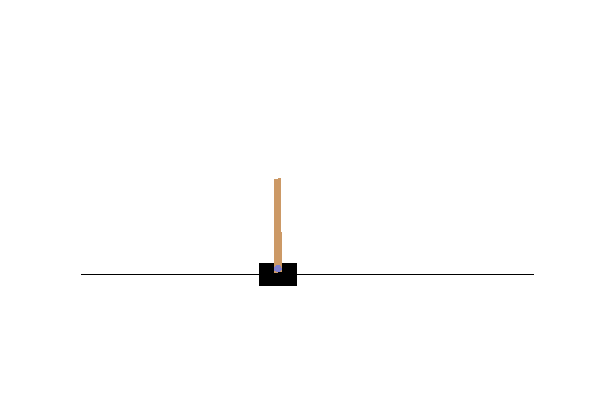
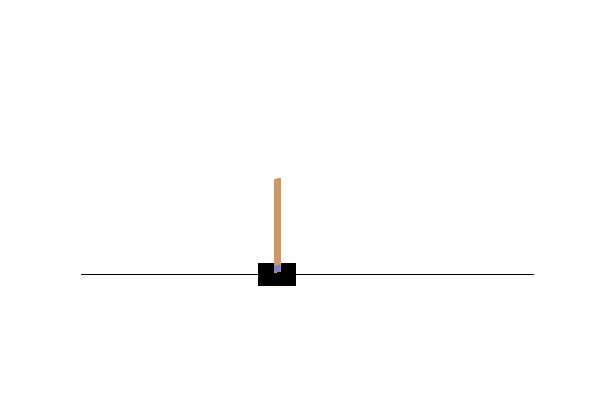
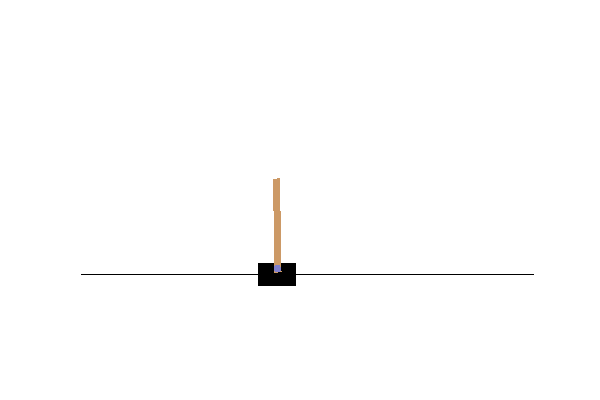
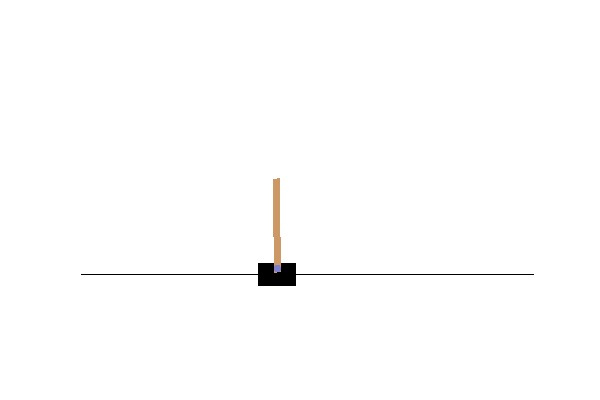
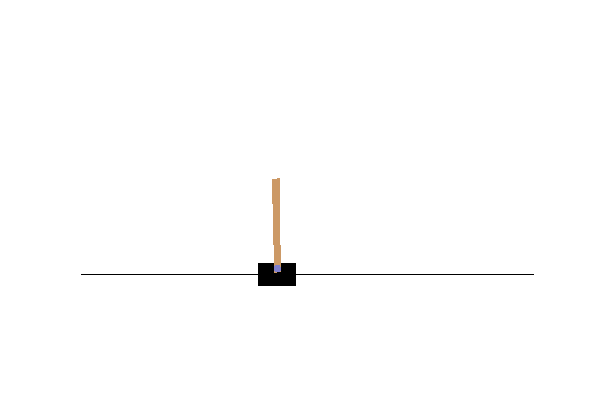
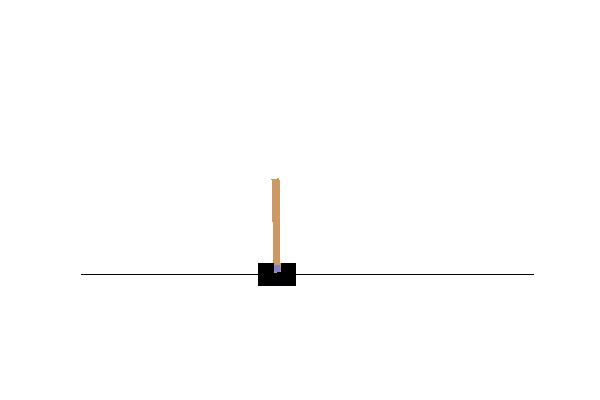
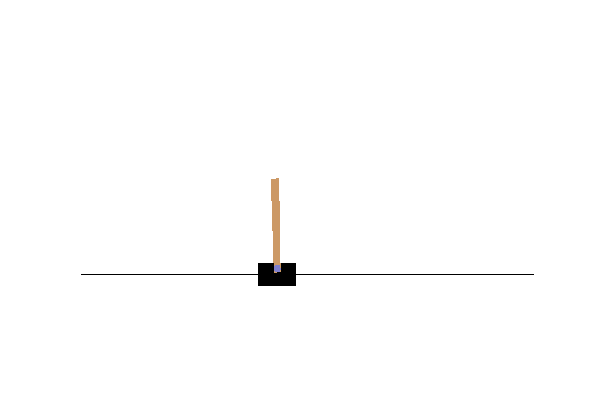
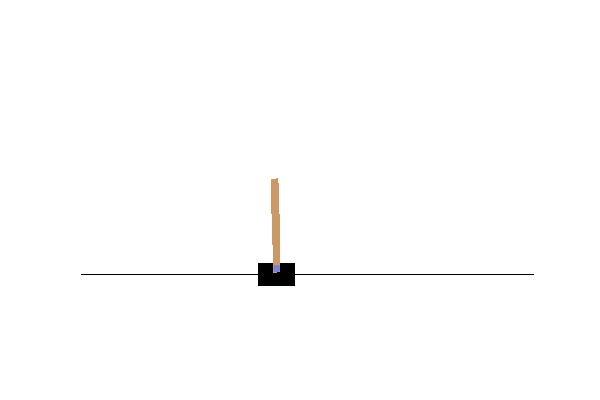
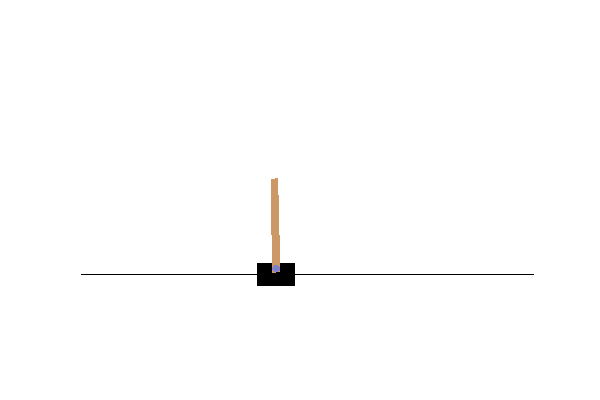
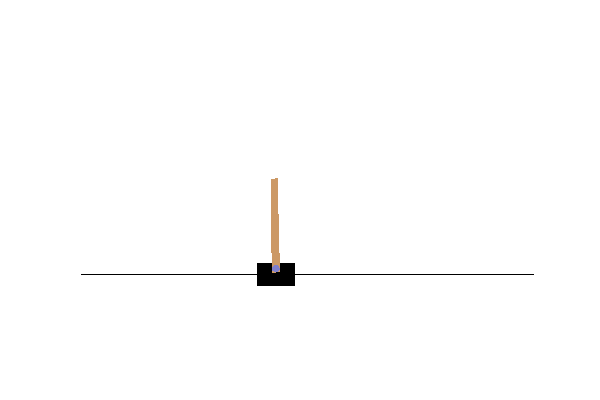
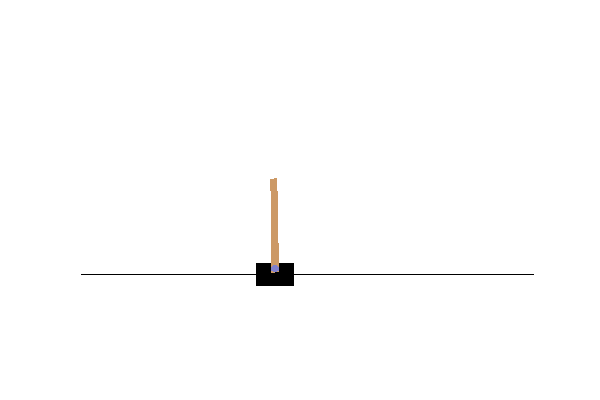
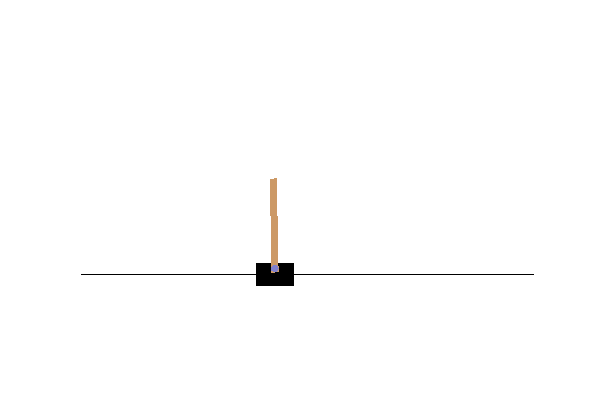
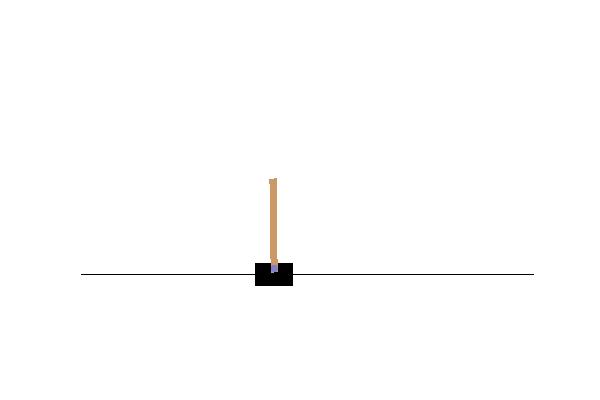
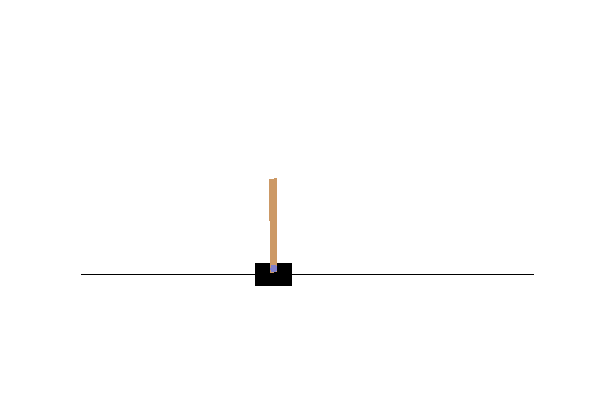
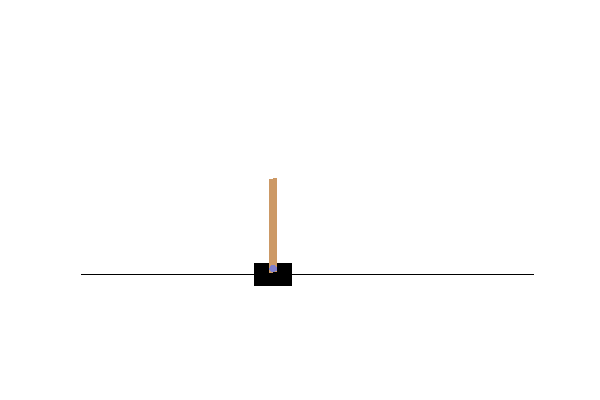
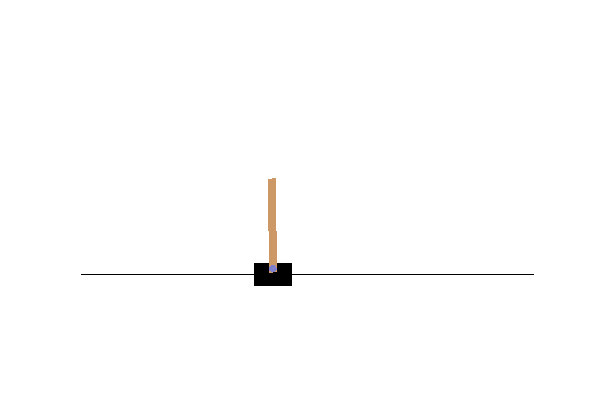
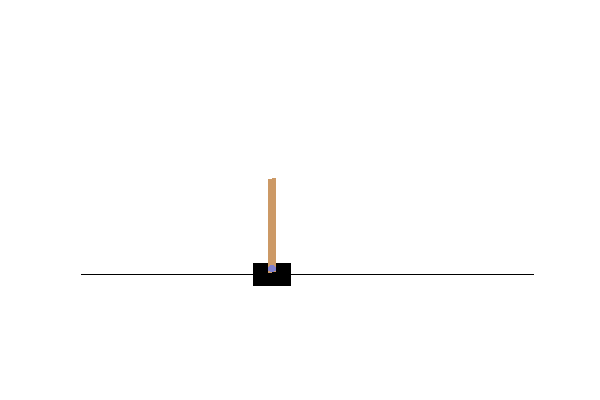
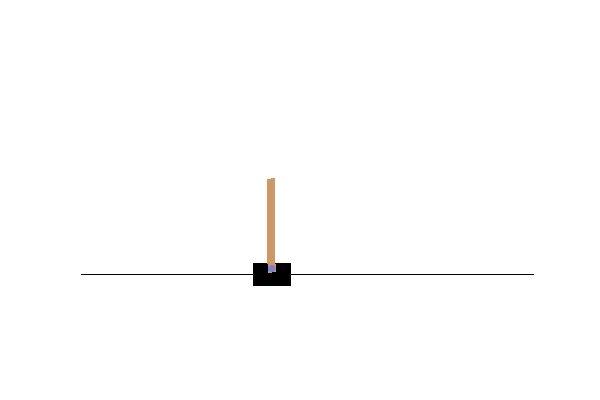
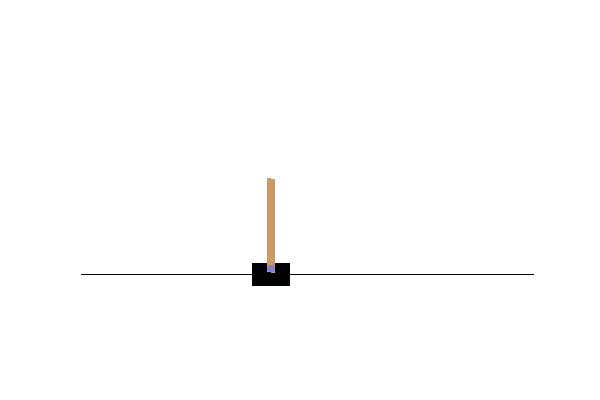
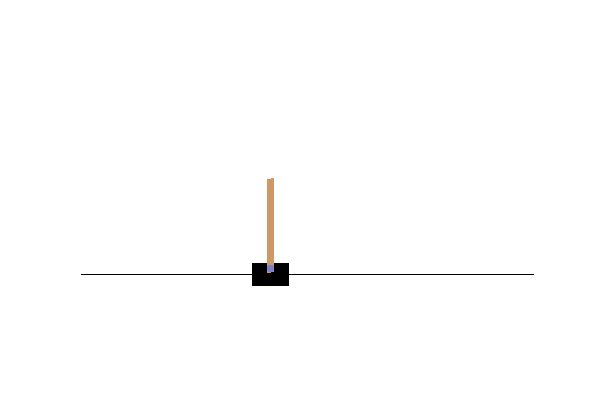
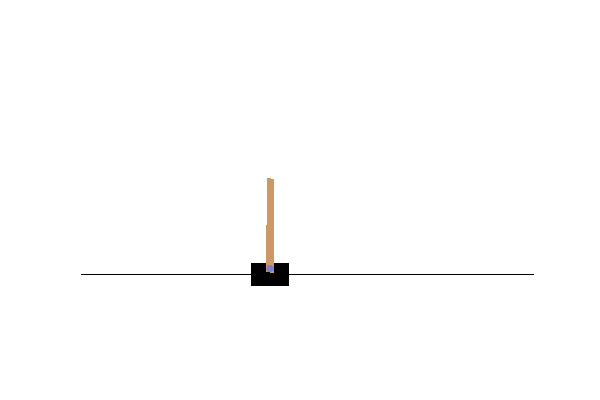
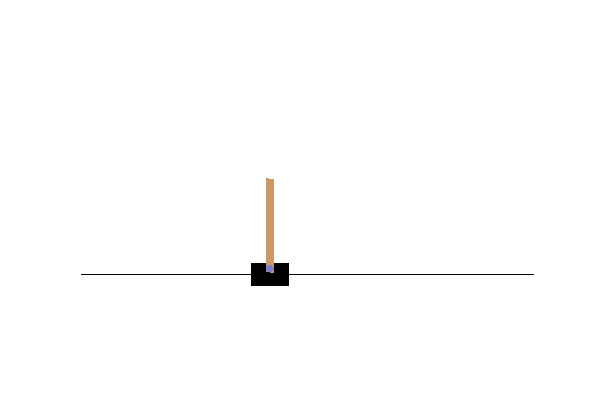
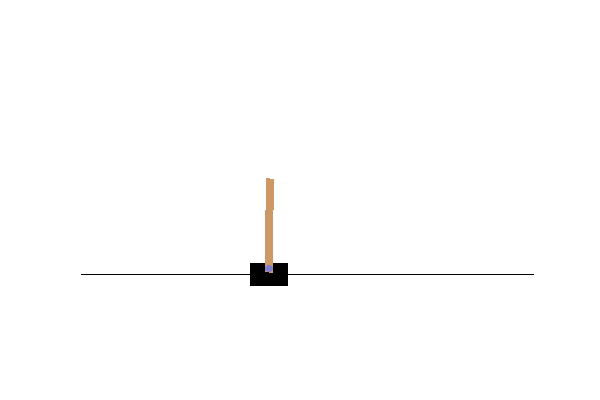
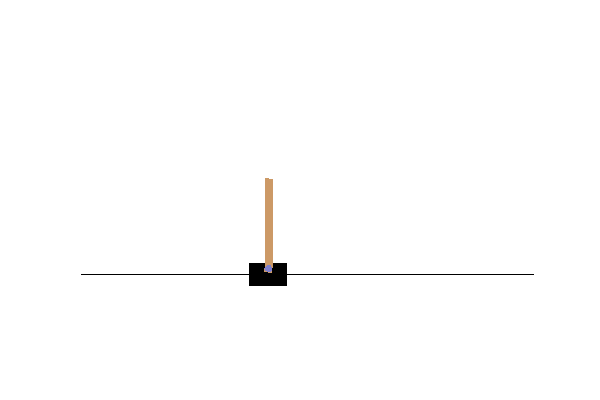
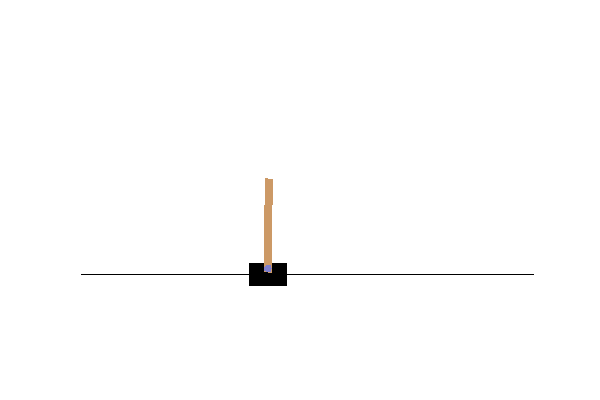
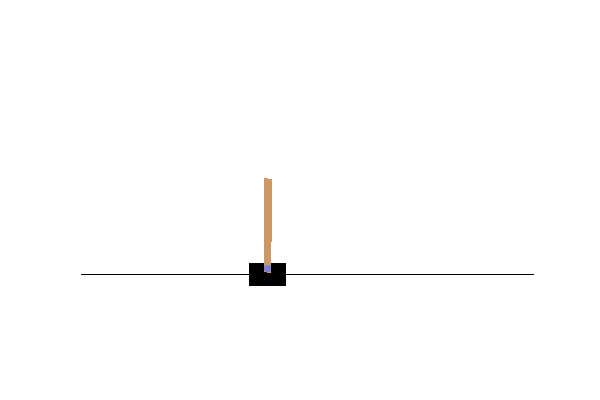
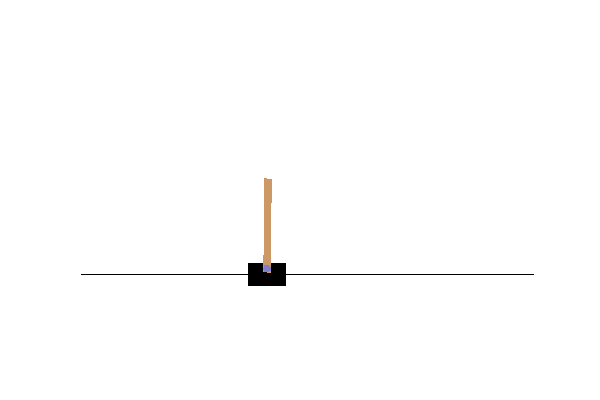
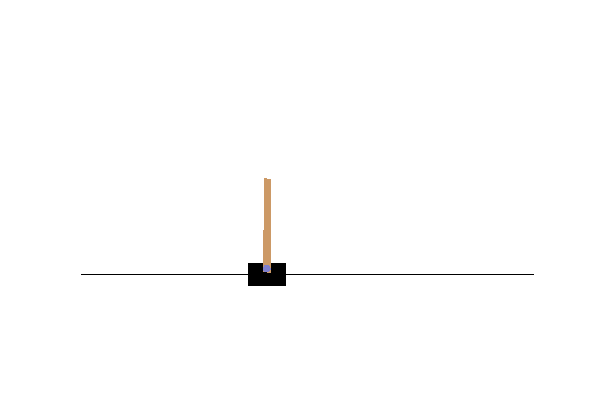
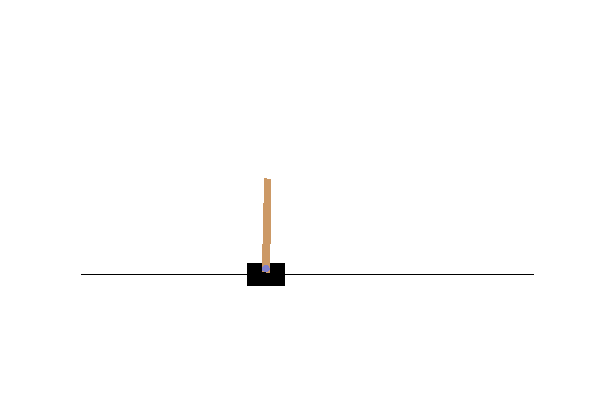
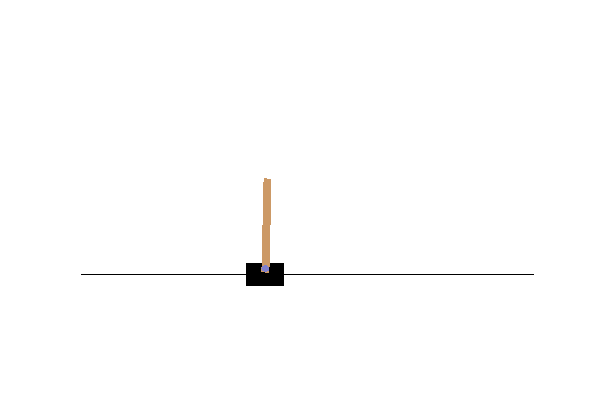
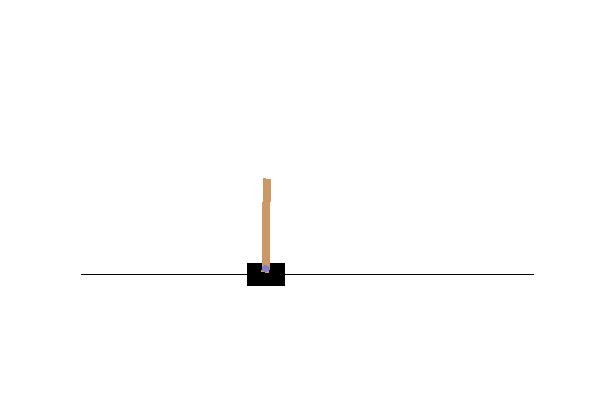
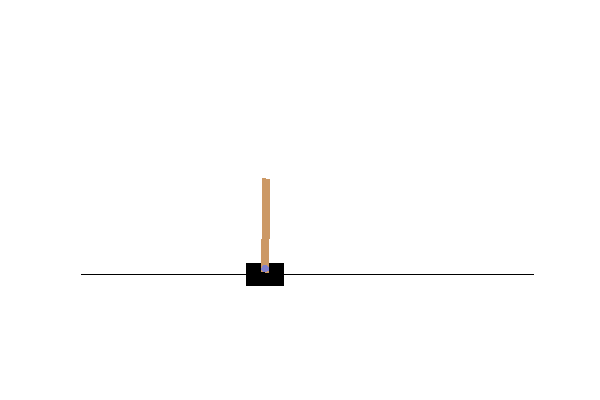
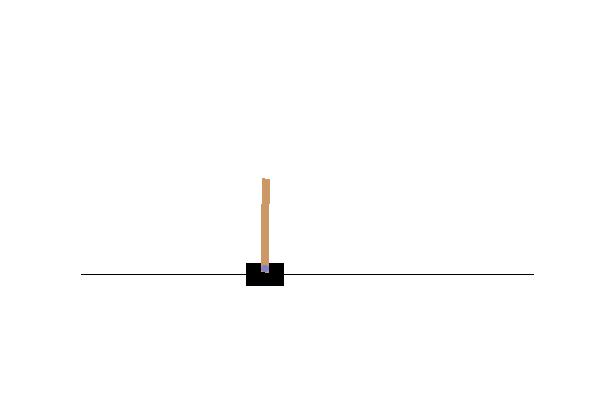
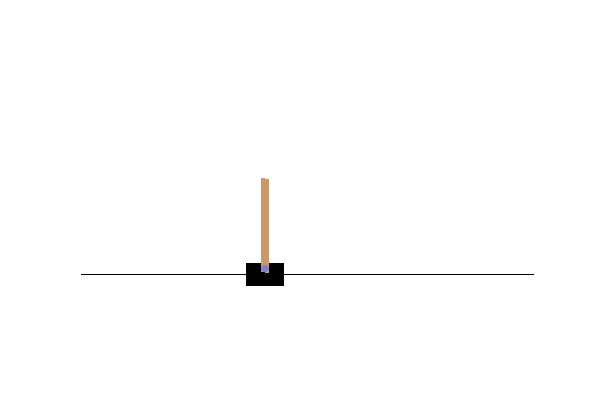
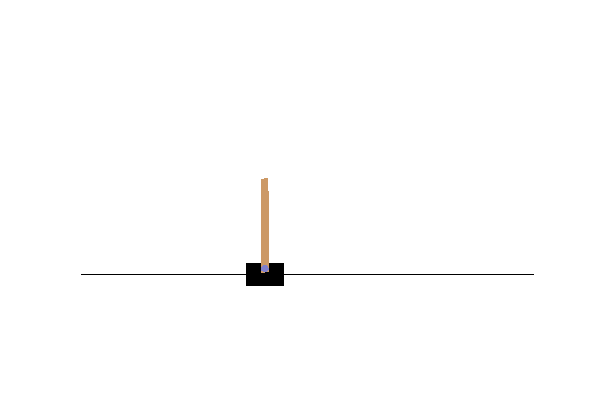
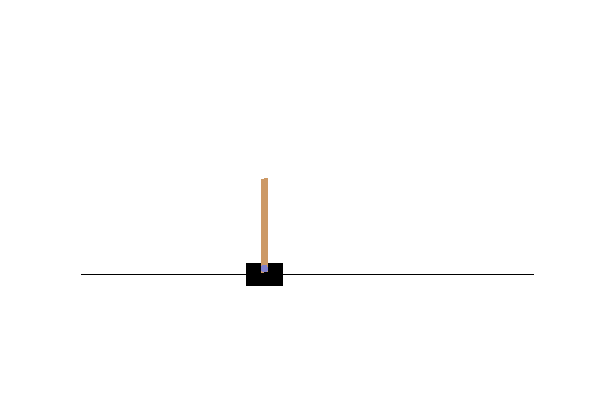
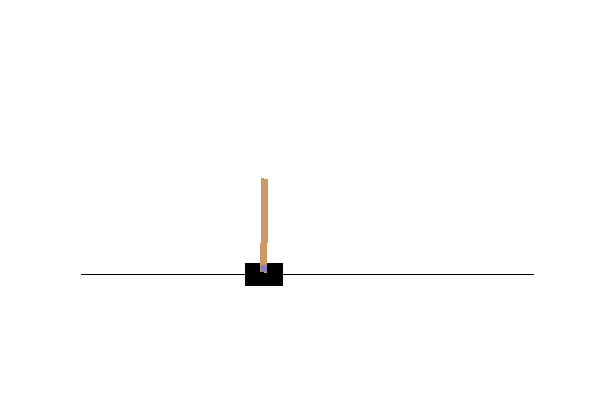
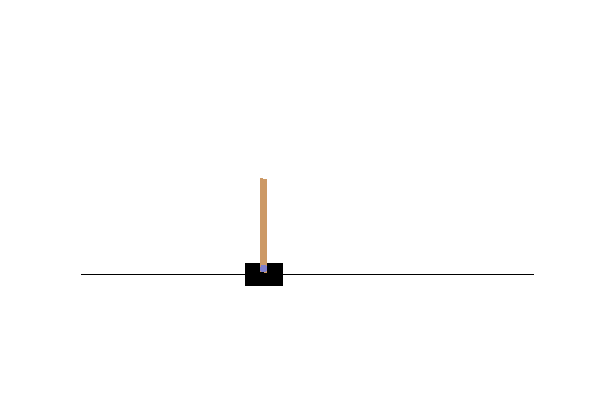
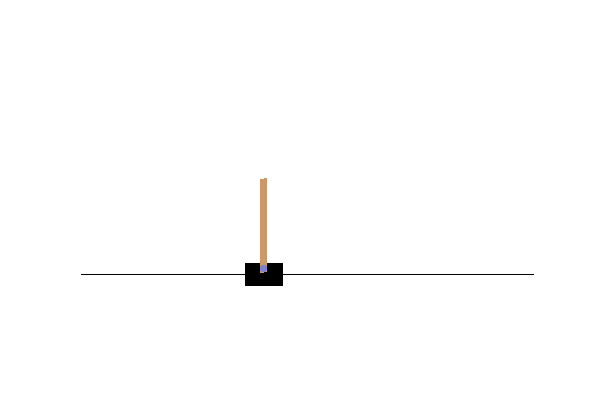
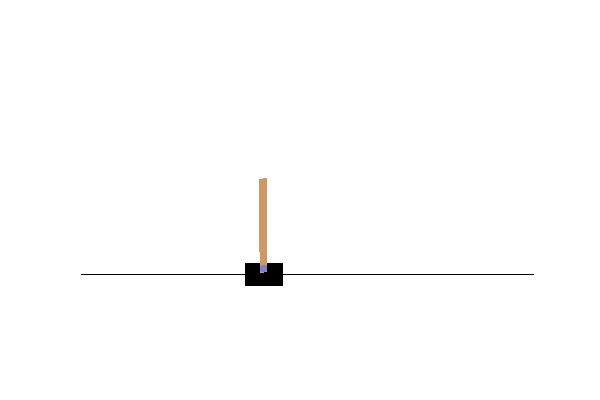
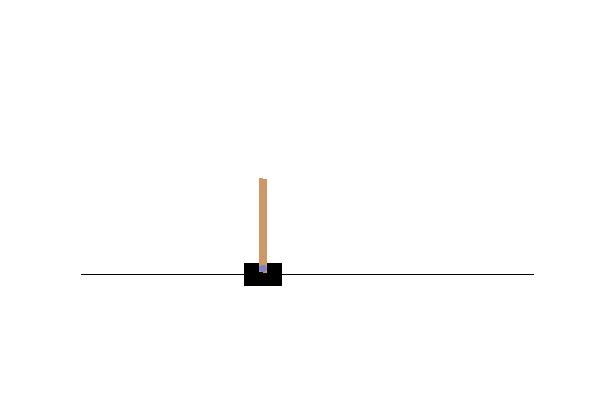
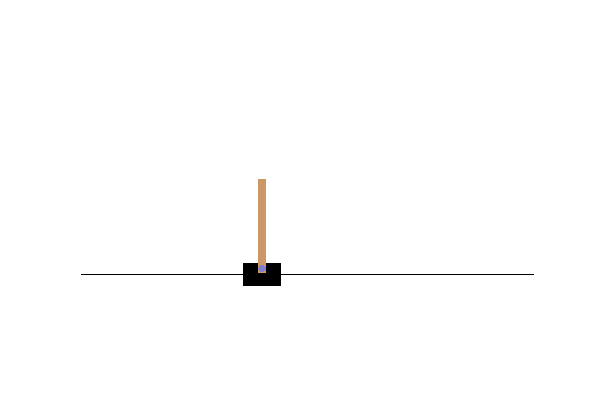
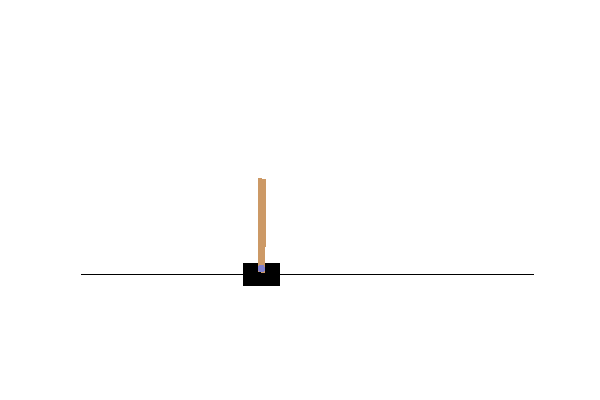
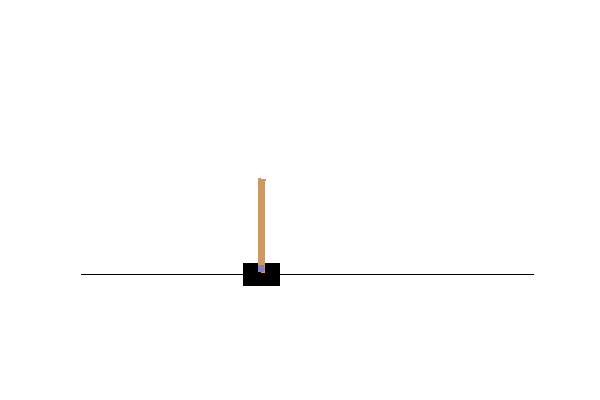
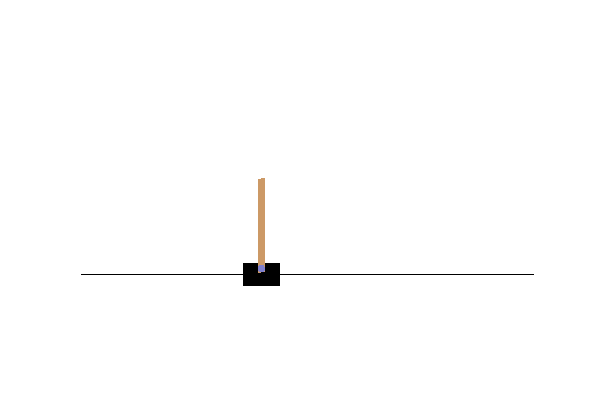
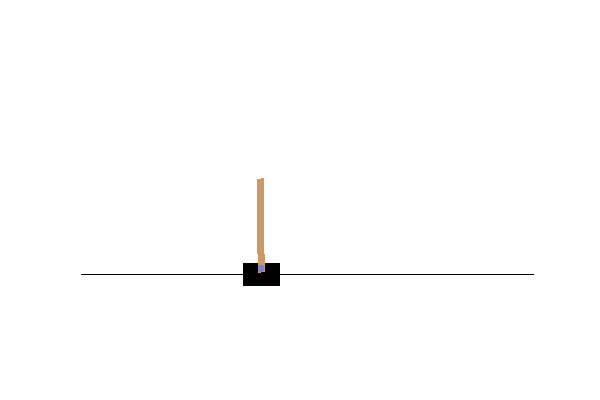
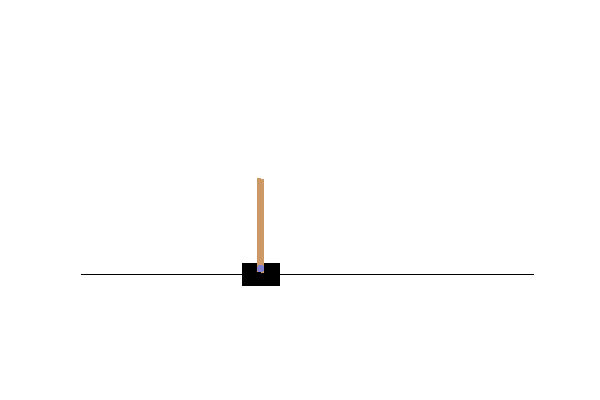
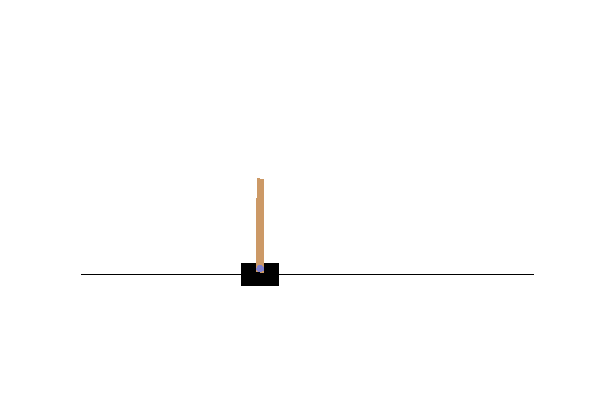
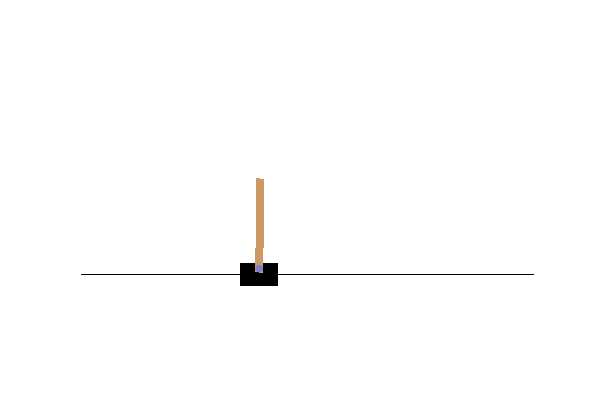
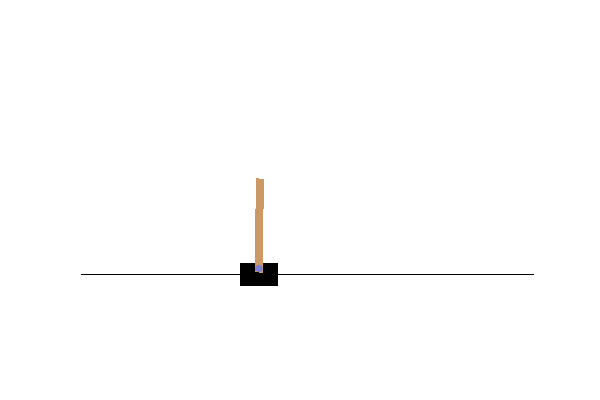
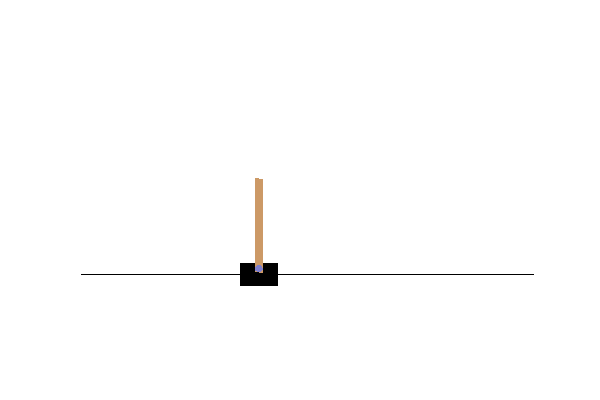
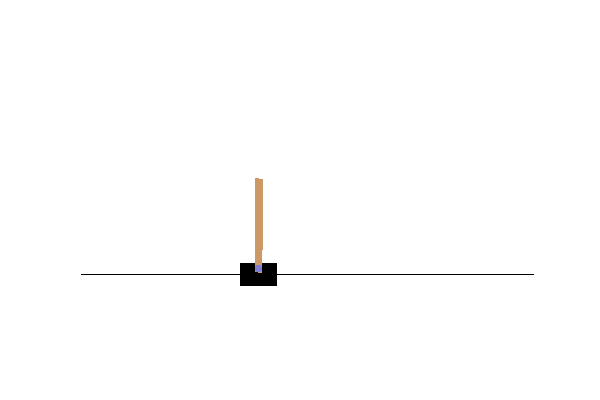
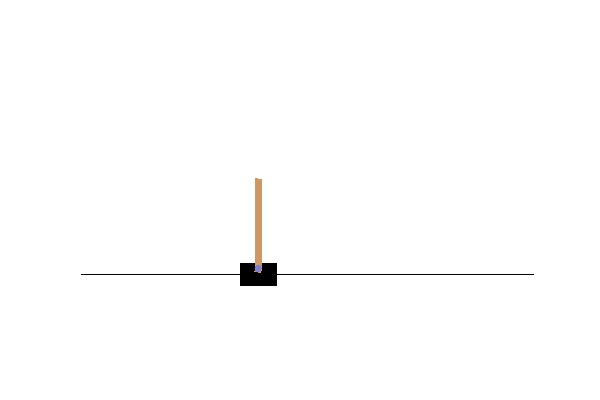
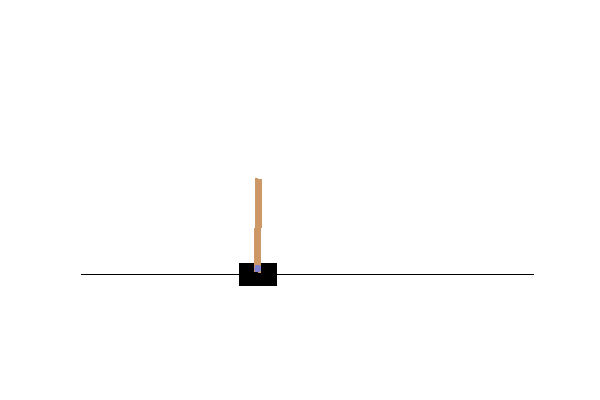
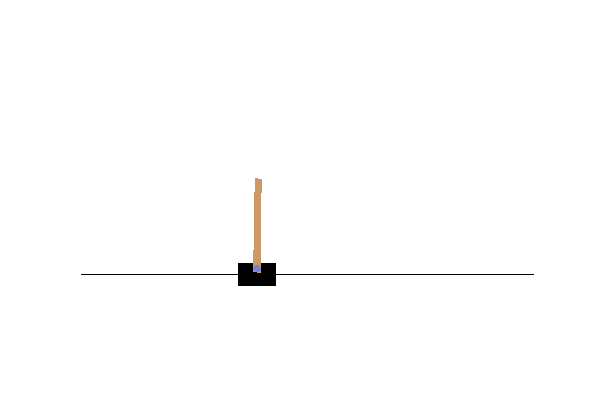
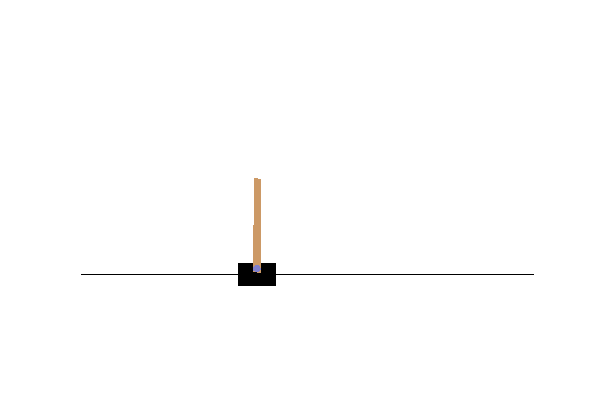
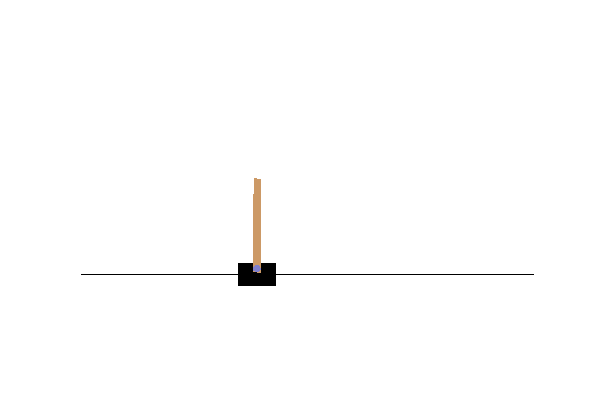
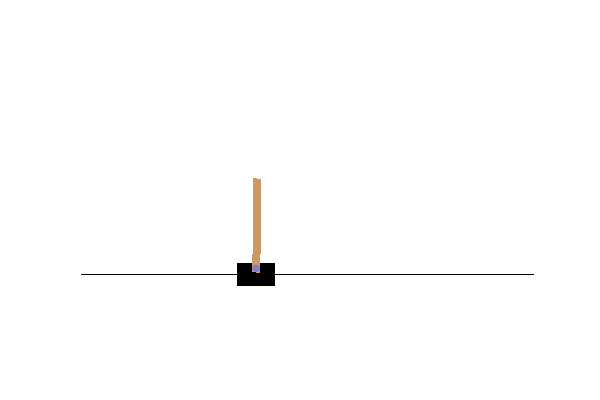
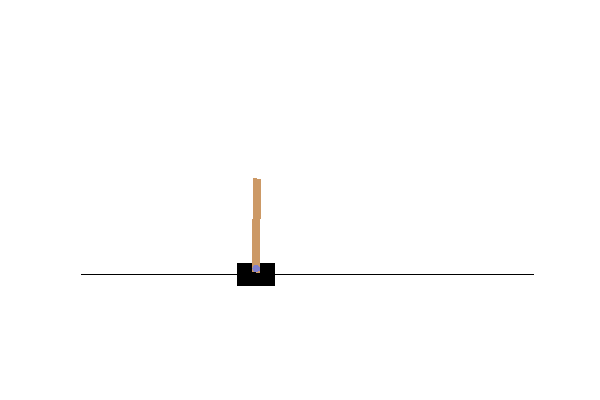
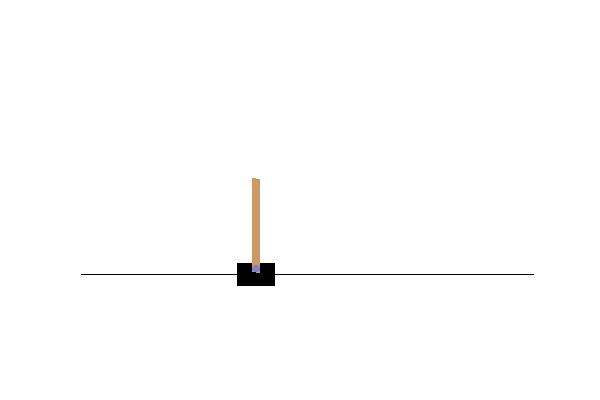
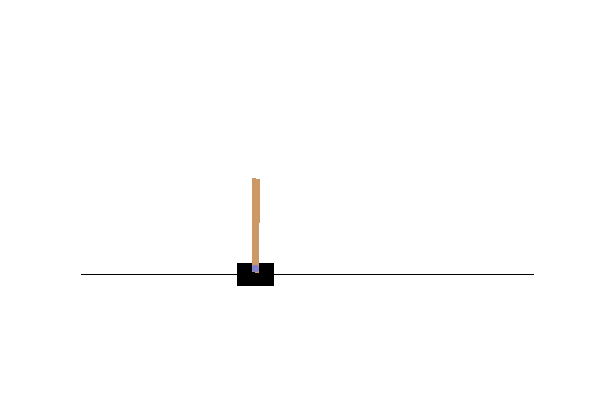
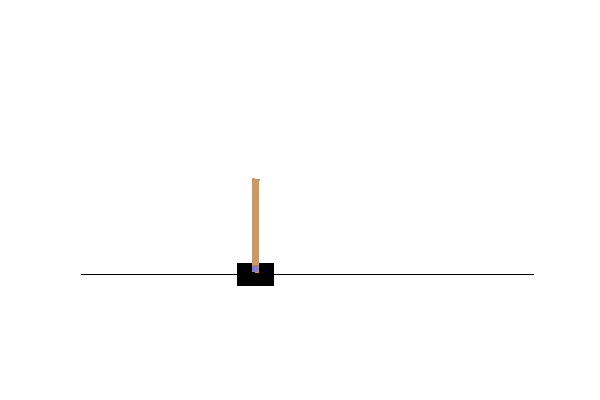
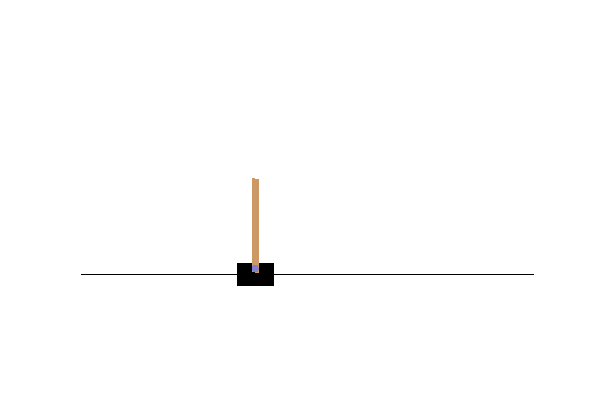
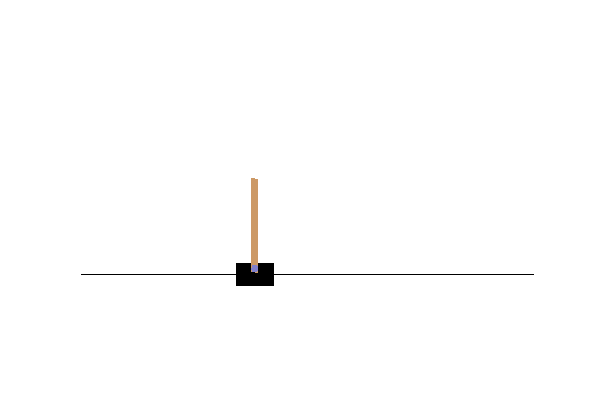
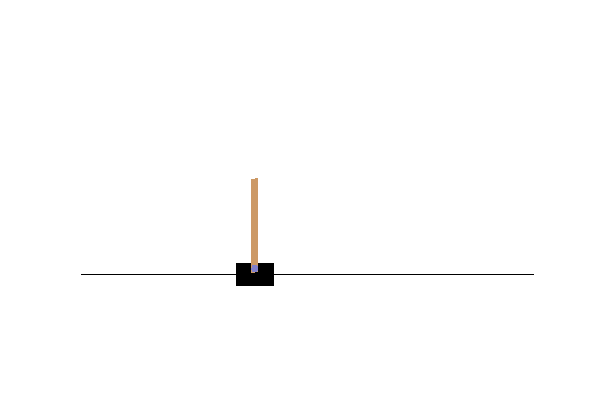
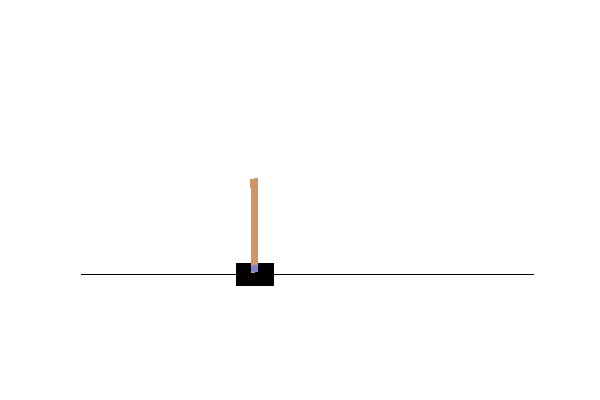
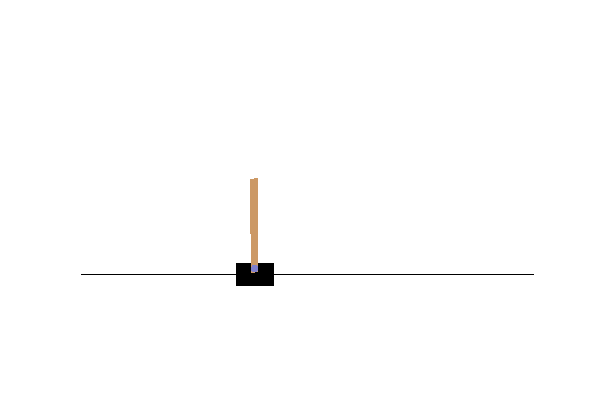
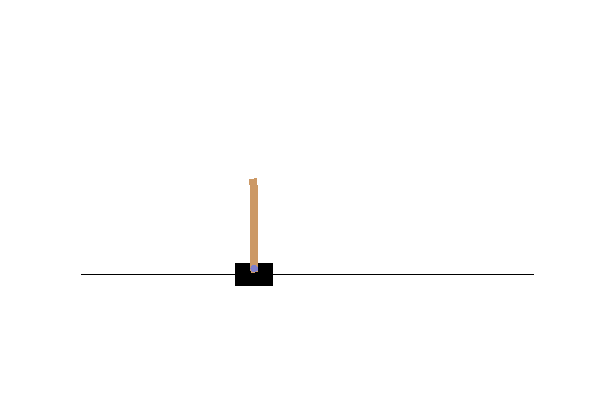
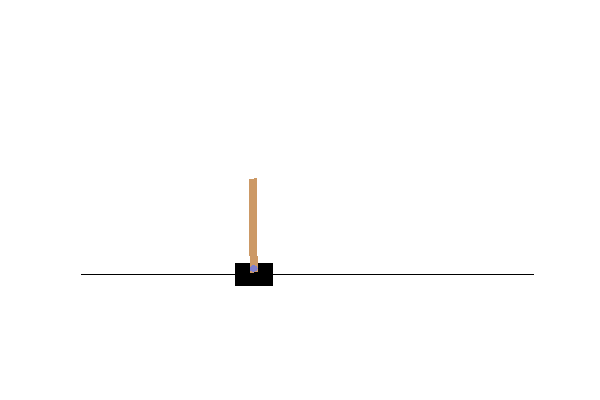
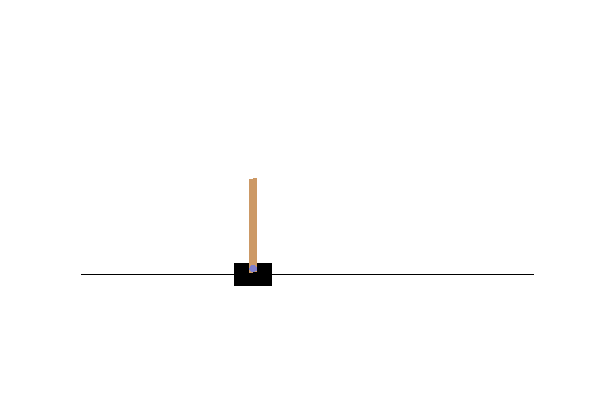
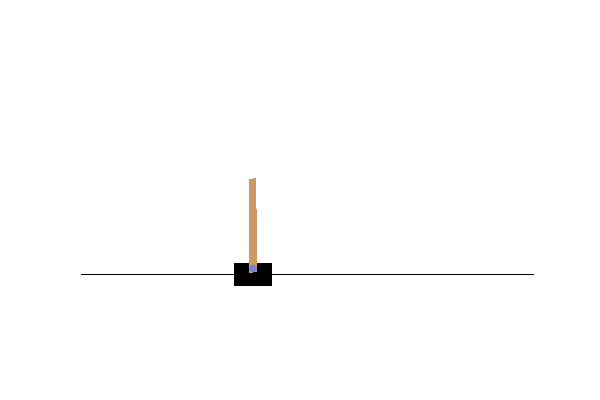
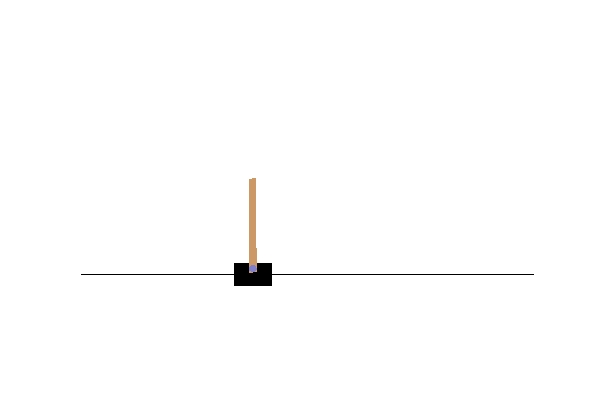
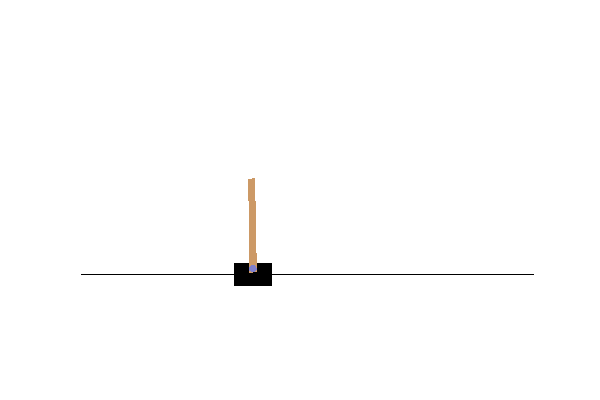
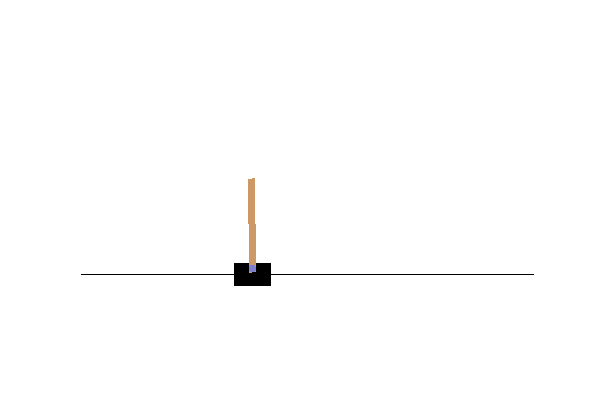
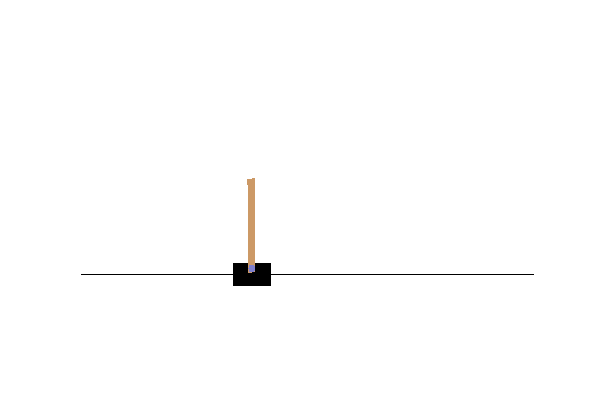
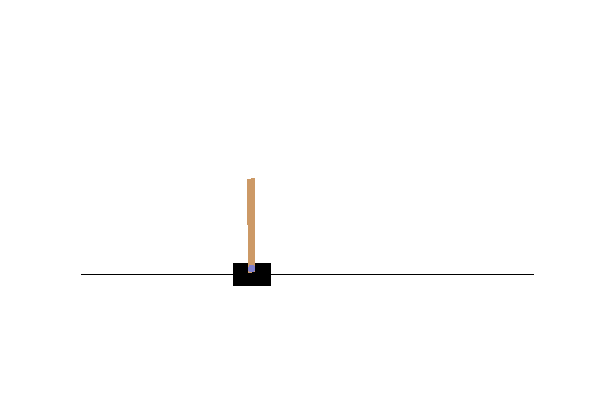
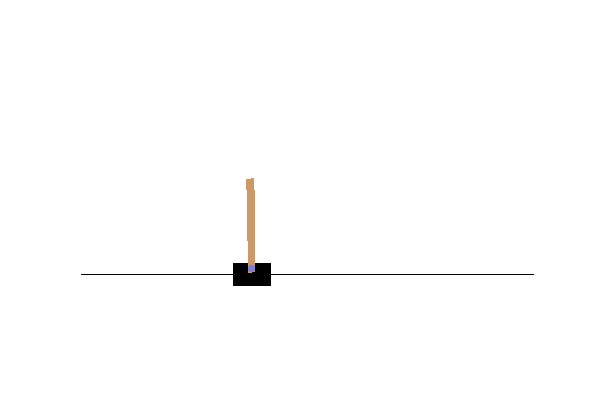
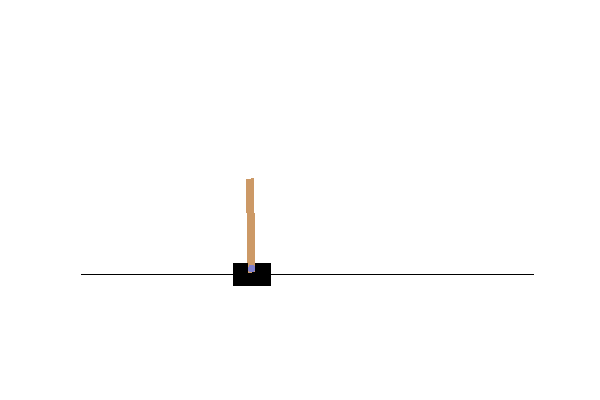
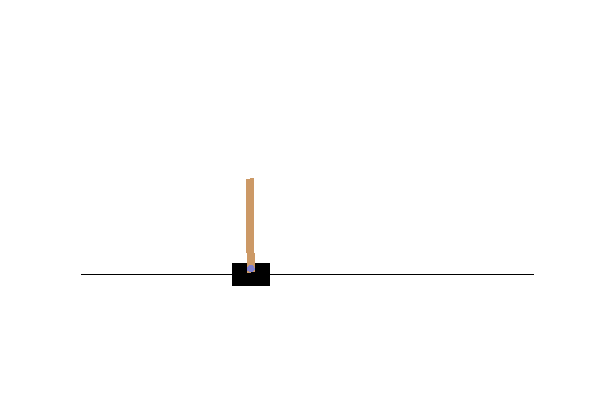
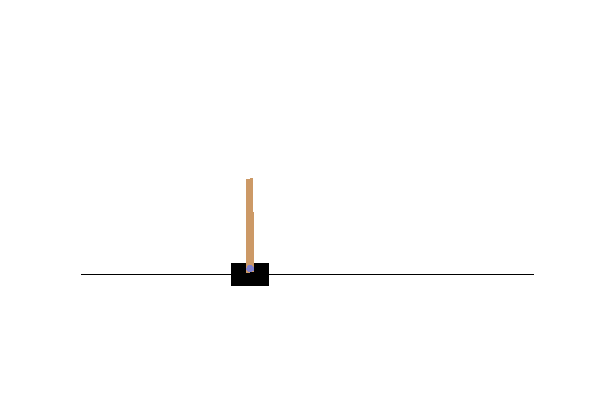
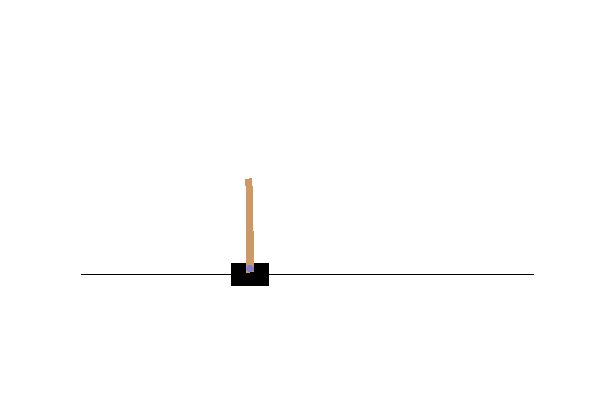
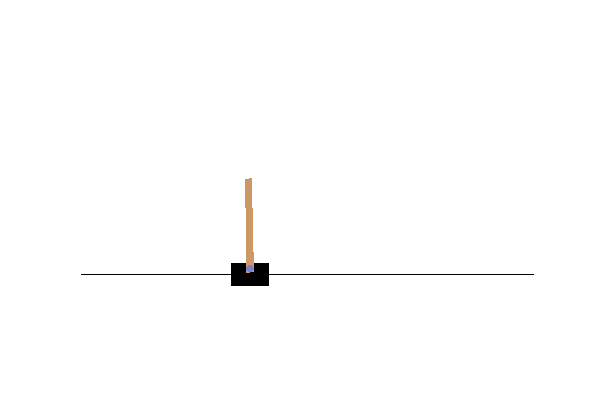
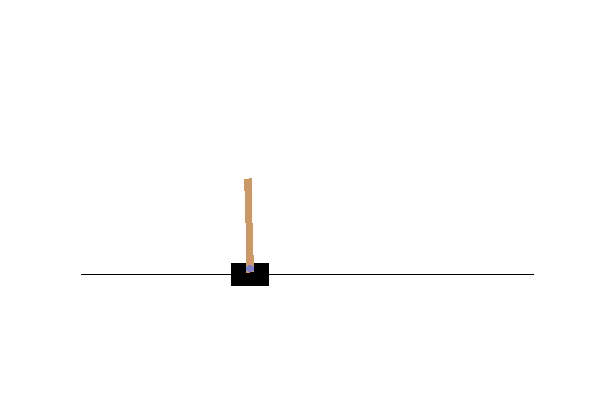
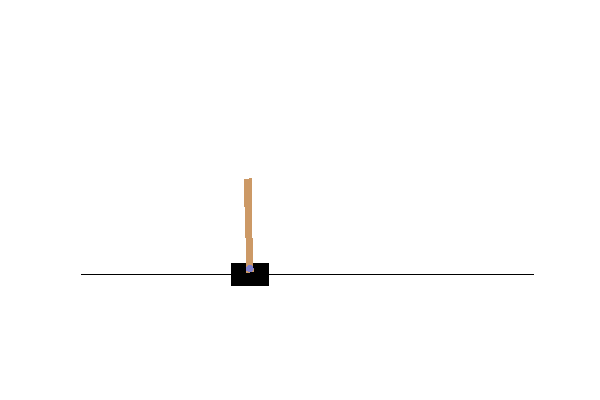
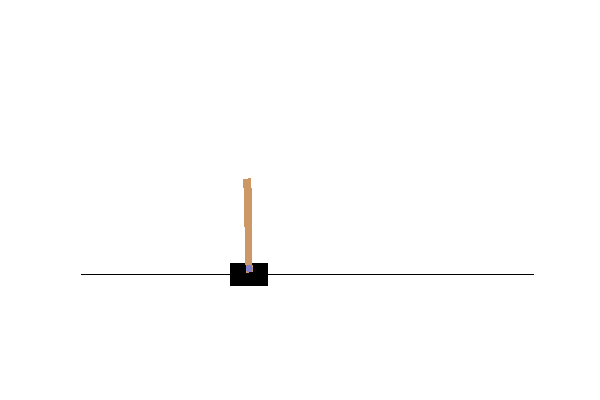
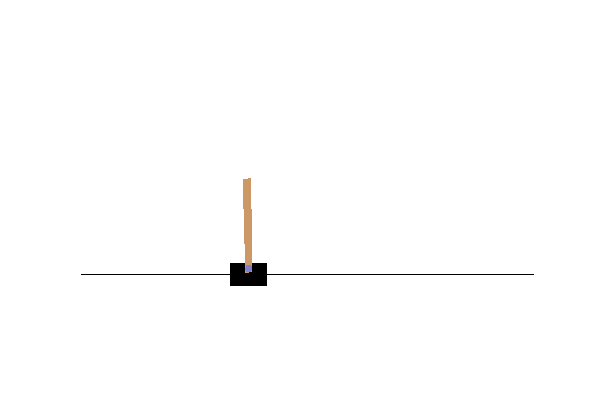
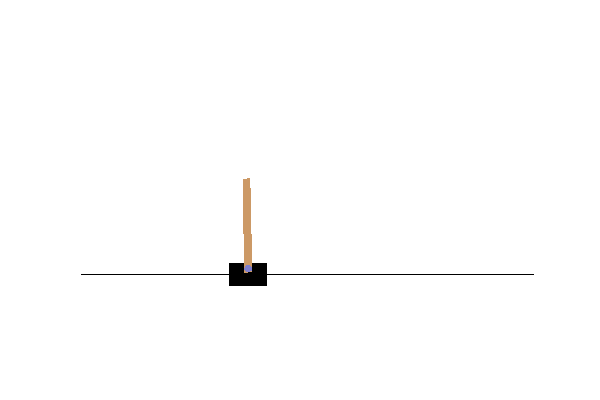
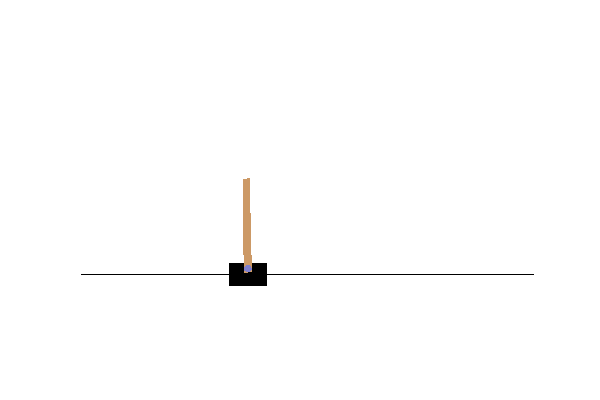
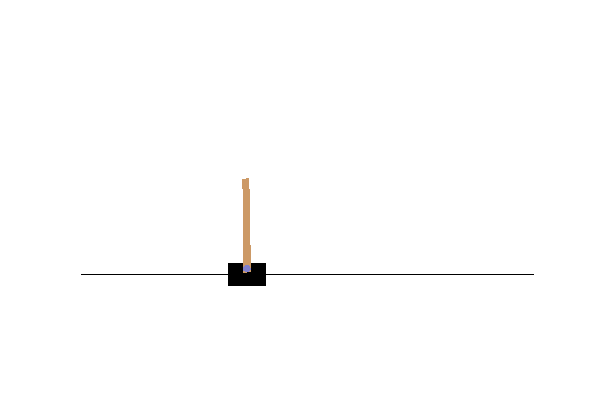
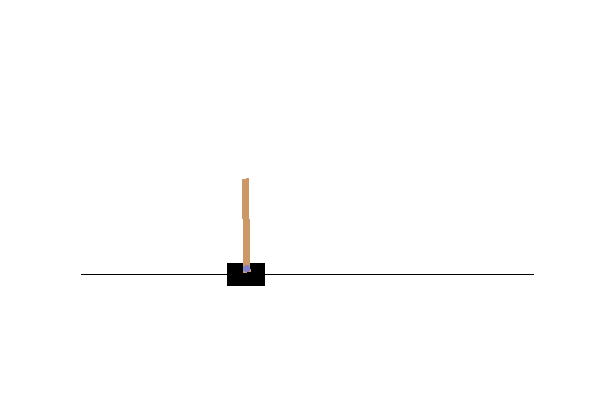
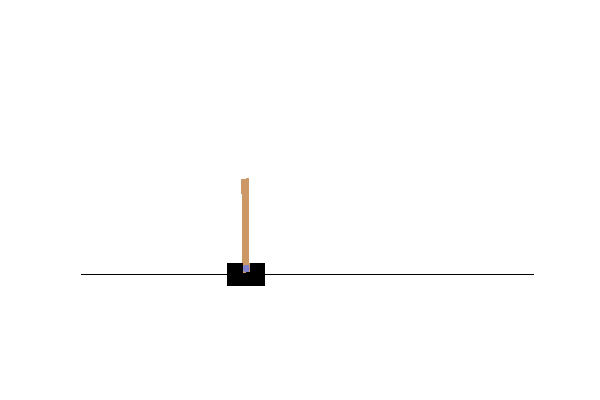

In [10]:
cartpole_env = Environment()
cartpole_env.run()